In [1]:
# 12151411 심경수

import random
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors
%matplotlib inline

In [2]:
# 카드 덱 클래스
class Deck(object) :
    
    # 생성 시 초기화 함수
    def __init__(self) :
        deck = [2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 11] # 카드는 A, 2, 3, ..., 10, J, Q, K
        self.card_deck = deck * 4                           # 종류는 4개 (스페이드, 클로버, 다이아, 하트)
        self.shuffle()                                      # 생성과 동시에 섞는다.
        
    # 덱 셔플
    def shuffle(self):
        random.shuffle(self.card_deck)
        
    # 카드 1장 뽑기
    def draw(self):
        return self.card_deck.pop()
    
    # 남은 카드 수 확인
    def left_cards(self) :
        return self.left_card
    
    # 덱 초기화 (처음 상태로 되돌리기, Init와 같은 내용 수행)
    def reset(self):
        deck = [2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 11]
        self.card_deck = deck * 4
        self.shuffle()

In [3]:
# 딜러 클래스
class Dealer(object) :
    
    # 생성 시 초기화 함수
    def __init__(self) :
        self.hands = list()                                 # 들고 있는 카드 리스트 초기화
        self.usable_ace = list()                           # Ace 존재여부 초기화
        
    # hit : 카드 1장을 뽑는다. 해당 카드가 Ace이면 사용 가능한 Ace 리스트에 추가
    def hit(self, deck: Deck) :
        new_card = deck.draw()                              # 카드 1장 뽑기
        if new_card == 11 :                                   # 해당 카드가 Ace일 경우
            self.usable_ace.append(len(self.hands))           # Ace 인덱스 저장
        self.hands.append(new_card)
        
    # 1장 보여주는 과정
    def show(self) :
        card = random.choice(self.hands)                # 보유한 카드 중 무작위로 1장 선정
        if card == 11 :                                # Ace를 뽑으면 1으로 간주
            card = 1
        return card
    
    # 손에 있는 카드의 합계 계산, Ace가 포함 여부에 따라 연산이 달라진다.
    def calculate_sum(self) :
        sums = sum(self.hands)
        if sums > 21 and len(self.usable_ace) > 0 :  # 합계가 21을 넘는데 Ace가 존재할 경우
            self.hands[self.usable_ace.pop()] = 1     # Ace를 1으로 간주한다.
            sums = sum(self.hands)
        return sums
    
    # 딜러 차례에서의 행동
    def action(self, deck: Deck) :
        while True :
            sums = self.calculate_sum()               # 본인의 합계 집계
            if sums < 17 :                            # 16이하면 한장 더 뽑는다.
                self.hit(deck)
            else :
                return sums                          # 17 이상일 경우 stick(중단, 합계를 반환)
    
    # 플레이어의 Action을 받아 진행할 것인가, 종료할 것인가를 결정하는 함수
    def observation(self, action, agent, deck) :
        done = False
        reward = 0
        if action == True :
            agent.hit(deck)
            if agent.calculate_sum() > 21 :     # 패배 : 플레이어의 총 합이 21을 초과할 경우
                done = True                     # 에피소드 종료 
                reward = -1                     # 마이너스 보상 부여
        else :
            done = True                         # 게임 종료, 점수 및 보상 집계
            reward = self.calculate_reward(agent, deck)
            
        return done, reward
    
    # 점수 집계
    def calculate_reward(self, agent, deck) : 
        agent_sum = agent.calculate_sum()       # 플레이어의 카드 합계
        if agent_sum > 21 :                     # 플레이어의 합계가 21을 초과하면
            return -1                          # Burst (딜러의 점수에 관계없이 패배)
        
        dealer_sum = self.action(deck)          # 딜러의 카드 합계
        if dealer_sum > 21 :                    # 딜러의 총합이 21을 초과하면 플레이어의 승리
            return 1
        if dealer_sum > agent_sum :             # 딜러의 총합이 플레이어보다 크면 딜러의 승리
            return -1
        if dealer_sum < agent_sum :             # 딜러의 총합이 플레이어보다 낮으면 플레이어의 승리
            return 1
        return 0                                # 총합이 동일한 경우 비김, 보상 없음

    # 새로운 에피소드를 위한 딜러 초기화
    def reset(self) :
        self.hands = list()
        self.usable_ace = list()

In [4]:
# 플레이어(Agent) 클래스
class Agent(object) :
    
    # 생성 시 초기화 함수
    def __init__(self) :
        self.hands = list()
        self.usable_ace = list()
        self.Q_table = dict()
        
    # hit : 카드 1장을 뽑는다.
    def hit(self, deck: Deck) :
        new_card = deck.draw()
        if new_card == 11 :                          # 뽑은 카드가 Ace 일 경우, Ace의 인덱스 저장
            self.usable_ace.append(len(self.hands))
        self.hands.append(new_card)
    
    # 손에 있는 카드의 합계 계산, Ace가 포함 여부에 따라 연산이 달라진다.
    def calculate_sum(self) :
        sums = sum(self.hands)
        if sums > 21 and len(self.usable_ace) > 0 :  # 합계가 21을 넘는데 Ace가 존재할 경우
            self.hands[self.usable_ace.pop()] = 1     # Ace를 1으로 간주 (합계를 21 이하로 낮춤)
            sums = sum(self.hands)
        return sums
    
    # 플레이어의 다음 행동을 무작위로 선정 (True : hit, False : stick)
    def random_action(self) :
        return random.choice([True, False])
    
    # Policy 함수
    def policy(self, state) :
        
        # Q_table에서 현재 state-action에 대해 값이 존재하는지 검사
        for action in (True, False) :
            if (state, action) not in self.Q_table.keys() :   # 없으면
                self.Q_table[(state, action)] = [0, 0]         # 0으로 초기화
            else :
                continue
        
        # Q 값이 큰 action을 선택
        if self.Q_table[(state, True)] > self.Q_table[(state, False)] :
            return True
        elif self.Q_table[(state, True)] == self.Q_table[(state, False)] :
            return self.random_action()                       # 값이 동일하면 무작위 선택
        else :
            return False
        
    
    # 새로운 에피소드를 위한 플레이어 초기화 (평가지표인 Q_table은 초기화하지 않음)
    def reset(self) :
        self.hands = list()
        self.usable_ace = list()
    
    # 에피소드(게임 진행과정)으로부터 Q_table을 업데이트, 
    def update_qval(self, episode) : 
        total_return = 0
        for state, action, reward in episode[:: -1] :   # 뒤에서부터 확인 (역순으로)
            total_return += reward
            if(state, action) not in self.Q_table.keys() :         # state-action 쌍이 없으면
                self.Q_table[(state, action)] = [total_return, 1]       # 새로운 엔트리 생성
            else :                                                 # state-action 쌍이 존재하면
                prev_val = self.Q_table[(state, action)][0]             # 이전의 평균
                count = self.Q_table[(state, action)][1] + 1            # count 증가
                mean = prev_val + (total_return - prev_val) / count    # 새로 평균 계산
                self.Q_table[(state, action)] = [mean, count]           # 이것으로 업데이트

In [5]:
# Monte Carlo 방식의 강화학습 진행
class MonteCarlo(object) :
    
    # 한번의 게임마다 에피소드를 생성, 평가
    def generate_episode(self, dealer: Dealer, agent: Agent, deck: Deck) :
        
        # 모든 상태 초기화, 딜러와 플레이어는 카드를 2장씩 뽑는다.
        deck.reset()
        dealer.reset()
        agent.reset()
        agent.hit(deck)
        agent.hit(deck)
        dealer.hit(deck)
        dealer.hit(deck)
        
        # 딜러가 공개하는 1장의 카드
        dealer_show = dealer.show()
        
        # 에피소드 종료 여부
        done = False
        
        # 에피소드 순서
        episode = list()
        
        while not done :
            
            # 에피소드가 종료될 때 까지 state, action, reward를 생성
            sums = agent.calculate_sum()
            
            # agent : 합계가 12 이상이 될 때 까지 hit
            if sums < 12 :
                agent.hit(deck)
                continue
            
            # state 생성
            state = (sums, bool(agent.usable_ace), dealer_show)
            
            # action 생성 (에피소드가 없으면 무작위로 생성, 있으면 state에 따른 행동 수행)
            if len(episode) == 0 :
                action = agent.random_action()
            else :
                action = agent.policy(state)
            
            # agent의 행동 관찰을 바탕으로 dealer가 행위를 결정 (done - False : 끝나지 않음, True : 끝남)
            done, reward = dealer.observation(action, agent, deck)
            
            # 에피소드에 추가
            episode.append([state, action, reward])

        return episode
    
    # 에피소드를 생성, 딜러와 플레이어가 겨뤄 플레이어의 학습 진행
    def train(self, dealer: Dealer, agent: Agent, deck: Deck, it = 10000, verbose = True) :
        count = 0
        win = 0
        loss = 0
        draw = 0
        total_win = 0
        total_loss = 0
        total_draw = 0
        
        # 1000번 단위로 플레이 집계
        for i in range(it) :
            count += 1
            episode = self.generate_episode(dealer, agent, deck)
            agent.update_qval(episode)
            
            # 승, 패, 무승부 집계
            if episode[-1][-1] == 1 :
                win += 1
            elif episode[-1][-1] == 0 :
                draw += 1
            else :
                loss += 1
                
            if count % 1000 == 0 and verbose == True :
                # 1000번 수행의 승, 패, 무승부를 누적 전적에 집계
                total_win += win
                total_draw += draw
                total_loss += loss
                
                # 이번 차례의 1000번 수행의 결과, 누적 전적 결과 집계
                print("========== Training : Episode ", count, " ===========")
                print("Recent 1000 games win rate :{:.3f}%".format(win / (win + loss) * 100))
                print(" -- 1000 Games WIN :", win, "DRAW :", draw, "LOSS :", loss)
                print("Total win rate : {:.3f}%".format(total_win / (total_win + total_loss) * 100))
                print(" -- TOTAL Games WIN :", total_win, "DRAW :", total_draw, "LOSS :", total_loss, "\n")

                # 다시 1000번 수행을 위해 초기화
                win = 0
                loss = 0
                draw = 0

In [6]:
# Q값 시각화 함수
def plot_q_val(agent: Agent, usable_ace = True):
    fig = plt.figure()
    ax = Axes3D(fig)

    hands = set()
    dealer_show = set()

    for state, action in sorted(agent.Q_table.keys()):
        hands.add(state[0])
        dealer_show.add(state[2])

    Z_list = list()
    l = list()

    for d in dealer_show:
        l = []
        for hand in hands:
            if ((hand, usable_ace, d), True) not in agent.Q_table.keys():
                agent.Q_table[((hand, usable_ace, d), True)] = [0, 0]
            if ((hand, usable_ace, d), False) not in agent.Q_table.keys():
                agent.Q_table[((hand, usable_ace, d), False)] = [0, 0]
            v_val = max([agent.Q_table[((hand, usable_ace, d), True)][0], agent.Q_table[((hand, usable_ace, d), False)][0]])
            l.append(v_val)
        Z_list.append(l)

    Y = np.array(list(hands))
    X = np.array(list(dealer_show))
    if usable_ace:
        X, Y = np.meshgrid(X, Y)
    else:
        X, Y = np.meshgrid(X, Y)

    Z = np.array(Z_list).T

    ax.plot_wireframe(X, Y, Z)
    plt.show()

# 최적 policy 시각화 함수
def plot_action(agent: Agent, usable_ace=True):
    hands = set()
    dealer_show = set()

    for state, action in sorted(agent.Q_table.keys()):
        hands.add(state[0])
        dealer_show.add(state[2])

    Z_list = list()
    l = list()
    action = False

    for d in dealer_show:
        l = []
        for hand in hands:
            if ((hand, usable_ace, d), True) not in agent.Q_table.keys():
                agent.Q_table[((hand, usable_ace, d), True)] = [0, 0]
            if ((hand, usable_ace, d), False) not in agent.Q_table.keys():
                agent.Q_table[((hand, usable_ace, d), False)] = [0, 0]
            l.append(0 if agent.Q_table[((hand, usable_ace, d), True)][0] > agent.Q_table[((hand, usable_ace, d), False)][0] else 1)
        Z_list.append(l)

    Y = np.array(list(hands))
    X = np.array(list(dealer_show))
    if usable_ace:
        X, Y = np.meshgrid(X, Y)
    else:
        X, Y = np.meshgrid(X, Y)
    Z = np.array(Z_list).T

    data = Z[::-1,:]
    data = np.append(data, [0 for _ in range(Z[0].shape[0])]).reshape(-1,Z[0].shape[0])
    
    cmap=cm.coolwarm
    plt.imshow(data, cmap=cmap, extent=[1,11,11,21])

    plt.ylabel('Player hand')
    plt.xlabel('Dealer show')
    plt.show()
    return X, Y, Z

In [7]:
# 최적 Policy 학습
deck = Deck()
dealer = Dealer()
agent = Agent()
mc_es = MonteCarlo()

mc_es.train(dealer, agent, deck, it = 1000000)   # 100만번 학습 수행

========== Training : Episode  1000  ===========
Recent 1000 games win rate :32.796%
 -- 1000 Games WIN : 305 DRAW : 70 LOSS : 625
Total win rate : 32.796%
 -- TOTAL Games WIN : 305 DRAW : 70 LOSS : 625 

========== Training : Episode  2000  ===========
Recent 1000 games win rate :34.879%
 -- 1000 Games WIN : 331 DRAW : 51 LOSS : 618
Total win rate : 33.848%
 -- TOTAL Games WIN : 636 DRAW : 121 LOSS : 1243 

========== Training : Episode  3000  ===========
Recent 1000 games win rate :33.403%
 -- 1000 Games WIN : 319 DRAW : 45 LOSS : 636
Total win rate : 33.698%
 -- TOTAL Games WIN : 955 DRAW : 166 LOSS : 1879 

========== Training : Episode  4000  ===========
Recent 1000 games win rate :35.760%
 -- 1000 Games WIN : 334 DRAW : 66 LOSS : 600
Total win rate : 34.209%
 -- TOTAL Games WIN : 1289 DRAW : 232 LOSS : 2479 

========== Training : Episode  5000  ===========
Recent 1000 games win rate :35.884%
 -- 1000 Games WIN : 333 DRAW : 72 LOSS : 595
Total win rate : 34.540%
 -- TOTAL Games W

 -- TOTAL Games WIN : 13466 DRAW : 2460 LOSS : 25074 

========== Training : Episode  42000  ===========
Recent 1000 games win rate :33.263%
 -- 1000 Games WIN : 315 DRAW : 53 LOSS : 632
Total win rate : 34.900%
 -- TOTAL Games WIN : 13781 DRAW : 2513 LOSS : 25706 

========== Training : Episode  43000  ===========
Recent 1000 games win rate :35.021%
 -- 1000 Games WIN : 332 DRAW : 52 LOSS : 616
Total win rate : 34.903%
 -- TOTAL Games WIN : 14113 DRAW : 2565 LOSS : 26322 

========== Training : Episode  44000  ===========
Recent 1000 games win rate :34.398%
 -- 1000 Games WIN : 323 DRAW : 61 LOSS : 616
Total win rate : 34.891%
 -- TOTAL Games WIN : 14436 DRAW : 2626 LOSS : 26938 

========== Training : Episode  45000  ===========
Recent 1000 games win rate :32.975%
 -- 1000 Games WIN : 307 DRAW : 69 LOSS : 624
Total win rate : 34.849%
 -- TOTAL Games WIN : 14743 DRAW : 2695 LOSS : 27562 

========== Training : Episode  46000  ===========
Recent 1000 games win rate :38.983%
 -- 1000 Ga

========== Training : Episode  82000  ===========
Recent 1000 games win rate :35.016%
 -- 1000 Games WIN : 326 DRAW : 69 LOSS : 605
Total win rate : 34.929%
 -- TOTAL Games WIN : 26933 DRAW : 4893 LOSS : 50174 

========== Training : Episode  83000  ===========
Recent 1000 games win rate :33.797%
 -- 1000 Games WIN : 316 DRAW : 65 LOSS : 619
Total win rate : 34.916%
 -- TOTAL Games WIN : 27249 DRAW : 4958 LOSS : 50793 

========== Training : Episode  84000  ===========
Recent 1000 games win rate :37.104%
 -- 1000 Games WIN : 351 DRAW : 54 LOSS : 595
Total win rate : 34.942%
 -- TOTAL Games WIN : 27600 DRAW : 5012 LOSS : 51388 

========== Training : Episode  85000  ===========
Recent 1000 games win rate :38.045%
 -- 1000 Games WIN : 358 DRAW : 59 LOSS : 583
Total win rate : 34.979%
 -- TOTAL Games WIN : 27958 DRAW : 5071 LOSS : 51971 

========== Training : Episode  86000  ===========
Recent 1000 games win rate :36.575%
 -- 1000 Games WIN : 346 DRAW : 54 LOSS : 600
Total win rate : 34.

========== Training : Episode  124000  ===========
Recent 1000 games win rate :35.745%
 -- 1000 Games WIN : 336 DRAW : 60 LOSS : 604
Total win rate : 35.091%
 -- TOTAL Games WIN : 40914 DRAW : 7406 LOSS : 75680 

========== Training : Episode  125000  ===========
Recent 1000 games win rate :34.191%
 -- 1000 Games WIN : 319 DRAW : 67 LOSS : 614
Total win rate : 35.084%
 -- TOTAL Games WIN : 41233 DRAW : 7473 LOSS : 76294 

========== Training : Episode  126000  ===========
Recent 1000 games win rate :35.875%
 -- 1000 Games WIN : 334 DRAW : 69 LOSS : 597
Total win rate : 35.090%
 -- TOTAL Games WIN : 41567 DRAW : 7542 LOSS : 76891 

========== Training : Episode  127000  ===========
Recent 1000 games win rate :34.549%
 -- 1000 Games WIN : 322 DRAW : 68 LOSS : 610
Total win rate : 35.086%
 -- TOTAL Games WIN : 41889 DRAW : 7610 LOSS : 77501 

========== Training : Episode  128000  ===========
Recent 1000 games win rate :35.931%
 -- 1000 Games WIN : 332 DRAW : 76 LOSS : 592
Total win rate 

========== Training : Episode  164000  ===========
Recent 1000 games win rate :34.065%
 -- 1000 Games WIN : 326 DRAW : 43 LOSS : 631
Total win rate : 35.216%
 -- TOTAL Games WIN : 54281 DRAW : 9864 LOSS : 99855 

========== Training : Episode  165000  ===========
Recent 1000 games win rate :35.118%
 -- 1000 Games WIN : 328 DRAW : 66 LOSS : 606
Total win rate : 35.216%
 -- TOTAL Games WIN : 54609 DRAW : 9930 LOSS : 100461 

========== Training : Episode  166000  ===========
Recent 1000 games win rate :35.494%
 -- 1000 Games WIN : 334 DRAW : 59 LOSS : 607
Total win rate : 35.217%
 -- TOTAL Games WIN : 54943 DRAW : 9989 LOSS : 101068 

========== Training : Episode  167000  ===========
Recent 1000 games win rate :34.475%
 -- 1000 Games WIN : 322 DRAW : 66 LOSS : 612
Total win rate : 35.213%
 -- TOTAL Games WIN : 55265 DRAW : 10055 LOSS : 101680 

========== Training : Episode  168000  ===========
Recent 1000 games win rate :35.714%
 -- 1000 Games WIN : 335 DRAW : 62 LOSS : 603
Total win r

========== Training : Episode  204000  ===========
Recent 1000 games win rate :34.225%
 -- 1000 Games WIN : 320 DRAW : 65 LOSS : 615
Total win rate : 35.306%
 -- TOTAL Games WIN : 67691 DRAW : 12273 LOSS : 124036 

========== Training : Episode  205000  ===========
Recent 1000 games win rate :34.874%
 -- 1000 Games WIN : 332 DRAW : 48 LOSS : 620
Total win rate : 35.304%
 -- TOTAL Games WIN : 68023 DRAW : 12321 LOSS : 124656 

========== Training : Episode  206000  ===========
Recent 1000 games win rate :34.325%
 -- 1000 Games WIN : 323 DRAW : 59 LOSS : 618
Total win rate : 35.299%
 -- TOTAL Games WIN : 68346 DRAW : 12380 LOSS : 125274 

========== Training : Episode  207000  ===========
Recent 1000 games win rate :35.608%
 -- 1000 Games WIN : 334 DRAW : 62 LOSS : 604
Total win rate : 35.301%
 -- TOTAL Games WIN : 68680 DRAW : 12442 LOSS : 125878 

========== Training : Episode  208000  ===========
Recent 1000 games win rate :37.263%
 -- 1000 Games WIN : 354 DRAW : 50 LOSS : 596
Total w

========== Training : Episode  246000  ===========
Recent 1000 games win rate :36.073%
 -- 1000 Games WIN : 338 DRAW : 63 LOSS : 599
Total win rate : 35.300%
 -- TOTAL Games WIN : 81608 DRAW : 14815 LOSS : 149577 

========== Training : Episode  247000  ===========
Recent 1000 games win rate :38.624%
 -- 1000 Games WIN : 365 DRAW : 55 LOSS : 580
Total win rate : 35.313%
 -- TOTAL Games WIN : 81973 DRAW : 14870 LOSS : 150157 

========== Training : Episode  248000  ===========
Recent 1000 games win rate :36.117%
 -- 1000 Games WIN : 346 DRAW : 42 LOSS : 612
Total win rate : 35.317%
 -- TOTAL Games WIN : 82319 DRAW : 14912 LOSS : 150769 

========== Training : Episode  249000  ===========
Recent 1000 games win rate :36.246%
 -- 1000 Games WIN : 336 DRAW : 73 LOSS : 591
Total win rate : 35.320%
 -- TOTAL Games WIN : 82655 DRAW : 14985 LOSS : 151360 

========== Training : Episode  250000  ===========
Recent 1000 games win rate :34.652%
 -- 1000 Games WIN : 324 DRAW : 65 LOSS : 611
Total w

========== Training : Episode  285000  ===========
Recent 1000 games win rate :35.456%
 -- 1000 Games WIN : 334 DRAW : 58 LOSS : 608
Total win rate : 35.278%
 -- TOTAL Games WIN : 94486 DRAW : 17171 LOSS : 173343 

========== Training : Episode  286000  ===========
Recent 1000 games win rate :34.632%
 -- 1000 Games WIN : 329 DRAW : 50 LOSS : 621
Total win rate : 35.276%
 -- TOTAL Games WIN : 94815 DRAW : 17221 LOSS : 173964 

========== Training : Episode  287000  ===========
Recent 1000 games win rate :34.045%
 -- 1000 Games WIN : 319 DRAW : 63 LOSS : 618
Total win rate : 35.272%
 -- TOTAL Games WIN : 95134 DRAW : 17284 LOSS : 174582 

========== Training : Episode  288000  ===========
Recent 1000 games win rate :35.263%
 -- 1000 Games WIN : 335 DRAW : 50 LOSS : 615
Total win rate : 35.272%
 -- TOTAL Games WIN : 95469 DRAW : 17334 LOSS : 175197 

========== Training : Episode  289000  ===========
Recent 1000 games win rate :35.338%
 -- 1000 Games WIN : 329 DRAW : 69 LOSS : 602
Total w

========== Training : Episode  324000  ===========
Recent 1000 games win rate :37.957%
 -- 1000 Games WIN : 353 DRAW : 70 LOSS : 577
Total win rate : 35.311%
 -- TOTAL Games WIN : 107520 DRAW : 19503 LOSS : 196977 

========== Training : Episode  325000  ===========
Recent 1000 games win rate :36.491%
 -- 1000 Games WIN : 339 DRAW : 71 LOSS : 590
Total win rate : 35.314%
 -- TOTAL Games WIN : 107859 DRAW : 19574 LOSS : 197567 

========== Training : Episode  326000  ===========
Recent 1000 games win rate :36.567%
 -- 1000 Games WIN : 343 DRAW : 62 LOSS : 595
Total win rate : 35.318%
 -- TOTAL Games WIN : 108202 DRAW : 19636 LOSS : 198162 

========== Training : Episode  327000  ===========
Recent 1000 games win rate :34.431%
 -- 1000 Games WIN : 324 DRAW : 59 LOSS : 617
Total win rate : 35.315%
 -- TOTAL Games WIN : 108526 DRAW : 19695 LOSS : 198779 

========== Training : Episode  328000  ===========
Recent 1000 games win rate :34.889%
 -- 1000 Games WIN : 329 DRAW : 57 LOSS : 614
Tot

========== Training : Episode  364000  ===========
Recent 1000 games win rate :33.942%
 -- 1000 Games WIN : 316 DRAW : 69 LOSS : 615
Total win rate : 35.323%
 -- TOTAL Games WIN : 120867 DRAW : 21822 LOSS : 221311 

========== Training : Episode  365000  ===========
Recent 1000 games win rate :36.038%
 -- 1000 Games WIN : 342 DRAW : 51 LOSS : 607
Total win rate : 35.325%
 -- TOTAL Games WIN : 121209 DRAW : 21873 LOSS : 221918 

========== Training : Episode  366000  ===========
Recent 1000 games win rate :34.385%
 -- 1000 Games WIN : 316 DRAW : 81 LOSS : 603
Total win rate : 35.322%
 -- TOTAL Games WIN : 121525 DRAW : 21954 LOSS : 222521 

========== Training : Episode  367000  ===========
Recent 1000 games win rate :33.512%
 -- 1000 Games WIN : 313 DRAW : 66 LOSS : 621
Total win rate : 35.317%
 -- TOTAL Games WIN : 121838 DRAW : 22020 LOSS : 223142 

========== Training : Episode  368000  ===========
Recent 1000 games win rate :33.405%
 -- 1000 Games WIN : 311 DRAW : 69 LOSS : 620
Tot

 -- TOTAL Games WIN : 133724 DRAW : 24256 LOSS : 245020 

========== Training : Episode  404000  ===========
Recent 1000 games win rate :33.835%
 -- 1000 Games WIN : 315 DRAW : 69 LOSS : 616
Total win rate : 35.304%
 -- TOTAL Games WIN : 134039 DRAW : 24325 LOSS : 245636 

========== Training : Episode  405000  ===========
Recent 1000 games win rate :34.047%
 -- 1000 Games WIN : 318 DRAW : 66 LOSS : 616
Total win rate : 35.301%
 -- TOTAL Games WIN : 134357 DRAW : 24391 LOSS : 246252 

========== Training : Episode  406000  ===========
Recent 1000 games win rate :33.694%
 -- 1000 Games WIN : 311 DRAW : 77 LOSS : 612
Total win rate : 35.297%
 -- TOTAL Games WIN : 134668 DRAW : 24468 LOSS : 246864 

========== Training : Episode  407000  ===========
Recent 1000 games win rate :36.102%
 -- 1000 Games WIN : 339 DRAW : 61 LOSS : 600
Total win rate : 35.299%
 -- TOTAL Games WIN : 135007 DRAW : 24529 LOSS : 247464 

========== Training : Episode  408000  ===========
Recent 1000 games win rate 

========== Training : Episode  447000  ===========
Recent 1000 games win rate :34.542%
 -- 1000 Games WIN : 324 DRAW : 62 LOSS : 614
Total win rate : 35.298%
 -- TOTAL Games WIN : 148277 DRAW : 26925 LOSS : 271798 

========== Training : Episode  448000  ===========
Recent 1000 games win rate :34.325%
 -- 1000 Games WIN : 323 DRAW : 59 LOSS : 618
Total win rate : 35.296%
 -- TOTAL Games WIN : 148600 DRAW : 26984 LOSS : 272416 

========== Training : Episode  449000  ===========
Recent 1000 games win rate :36.702%
 -- 1000 Games WIN : 345 DRAW : 60 LOSS : 595
Total win rate : 35.299%
 -- TOTAL Games WIN : 148945 DRAW : 27044 LOSS : 273011 

========== Training : Episode  450000  ===========
Recent 1000 games win rate :35.768%
 -- 1000 Games WIN : 333 DRAW : 69 LOSS : 598
Total win rate : 35.300%
 -- TOTAL Games WIN : 149278 DRAW : 27113 LOSS : 273609 

========== Training : Episode  451000  ===========
Recent 1000 games win rate :35.737%
 -- 1000 Games WIN : 337 DRAW : 57 LOSS : 606
Tot

========== Training : Episode  488000  ===========
Recent 1000 games win rate :34.694%
 -- 1000 Games WIN : 323 DRAW : 69 LOSS : 608
Total win rate : 35.311%
 -- TOTAL Games WIN : 161911 DRAW : 29470 LOSS : 296619 

========== Training : Episode  489000  ===========
Recent 1000 games win rate :33.404%
 -- 1000 Games WIN : 313 DRAW : 63 LOSS : 624
Total win rate : 35.307%
 -- TOTAL Games WIN : 162224 DRAW : 29533 LOSS : 297243 

========== Training : Episode  490000  ===========
Recent 1000 games win rate :35.813%
 -- 1000 Games WIN : 337 DRAW : 59 LOSS : 604
Total win rate : 35.308%
 -- TOTAL Games WIN : 162561 DRAW : 29592 LOSS : 297847 

========== Training : Episode  491000  ===========
Recent 1000 games win rate :35.767%
 -- 1000 Games WIN : 338 DRAW : 55 LOSS : 607
Total win rate : 35.309%
 -- TOTAL Games WIN : 162899 DRAW : 29647 LOSS : 298454 

========== Training : Episode  492000  ===========
Recent 1000 games win rate :35.508%
 -- 1000 Games WIN : 332 DRAW : 65 LOSS : 603
Tot

========== Training : Episode  527000  ===========
Recent 1000 games win rate :34.497%
 -- 1000 Games WIN : 326 DRAW : 55 LOSS : 619
Total win rate : 35.340%
 -- TOTAL Games WIN : 174999 DRAW : 31809 LOSS : 320192 

========== Training : Episode  528000  ===========
Recent 1000 games win rate :35.300%
 -- 1000 Games WIN : 329 DRAW : 68 LOSS : 603
Total win rate : 35.340%
 -- TOTAL Games WIN : 175328 DRAW : 31877 LOSS : 320795 

========== Training : Episode  529000  ===========
Recent 1000 games win rate :33.795%
 -- 1000 Games WIN : 317 DRAW : 62 LOSS : 621
Total win rate : 35.337%
 -- TOTAL Games WIN : 175645 DRAW : 31939 LOSS : 321416 

========== Training : Episode  530000  ===========
Recent 1000 games win rate :38.065%
 -- 1000 Games WIN : 354 DRAW : 70 LOSS : 576
Total win rate : 35.342%
 -- TOTAL Games WIN : 175999 DRAW : 32009 LOSS : 321992 

========== Training : Episode  531000  ===========
Recent 1000 games win rate :36.702%
 -- 1000 Games WIN : 345 DRAW : 60 LOSS : 595
Tot

========== Training : Episode  565000  ===========
Recent 1000 games win rate :34.661%
 -- 1000 Games WIN : 322 DRAW : 71 LOSS : 607
Total win rate : 35.337%
 -- TOTAL Games WIN : 187602 DRAW : 34110 LOSS : 343288 

========== Training : Episode  566000  ===========
Recent 1000 games win rate :34.461%
 -- 1000 Games WIN : 326 DRAW : 54 LOSS : 620
Total win rate : 35.336%
 -- TOTAL Games WIN : 187928 DRAW : 34164 LOSS : 343908 

========== Training : Episode  567000  ===========
Recent 1000 games win rate :34.225%
 -- 1000 Games WIN : 320 DRAW : 65 LOSS : 615
Total win rate : 35.334%
 -- TOTAL Games WIN : 188248 DRAW : 34229 LOSS : 344523 

========== Training : Episode  568000  ===========
Recent 1000 games win rate :36.578%
 -- 1000 Games WIN : 342 DRAW : 65 LOSS : 593
Total win rate : 35.336%
 -- TOTAL Games WIN : 188590 DRAW : 34294 LOSS : 345116 

========== Training : Episode  569000  ===========
Recent 1000 games win rate :35.782%
 -- 1000 Games WIN : 341 DRAW : 47 LOSS : 612
Tot

========== Training : Episode  608000  ===========
Recent 1000 games win rate :33.794%
 -- 1000 Games WIN : 318 DRAW : 59 LOSS : 623
Total win rate : 35.343%
 -- TOTAL Games WIN : 201923 DRAW : 36675 LOSS : 369402 

========== Training : Episode  609000  ===========
Recent 1000 games win rate :35.653%
 -- 1000 Games WIN : 333 DRAW : 66 LOSS : 601
Total win rate : 35.343%
 -- TOTAL Games WIN : 202256 DRAW : 36741 LOSS : 370003 

========== Training : Episode  610000  ===========
Recent 1000 games win rate :34.936%
 -- 1000 Games WIN : 327 DRAW : 64 LOSS : 609
Total win rate : 35.343%
 -- TOTAL Games WIN : 202583 DRAW : 36805 LOSS : 370612 

========== Training : Episode  611000  ===========
Recent 1000 games win rate :33.762%
 -- 1000 Games WIN : 315 DRAW : 67 LOSS : 618
Total win rate : 35.340%
 -- TOTAL Games WIN : 202898 DRAW : 36872 LOSS : 371230 

========== Training : Episode  612000  ===========
Recent 1000 games win rate :35.987%
 -- 1000 Games WIN : 339 DRAW : 58 LOSS : 603
Tot

========== Training : Episode  646000  ===========
Recent 1000 games win rate :34.664%
 -- 1000 Games WIN : 330 DRAW : 48 LOSS : 622
Total win rate : 35.350%
 -- TOTAL Games WIN : 214595 DRAW : 38935 LOSS : 392470 

========== Training : Episode  647000  ===========
Recent 1000 games win rate :37.021%
 -- 1000 Games WIN : 348 DRAW : 60 LOSS : 592
Total win rate : 35.352%
 -- TOTAL Games WIN : 214943 DRAW : 38995 LOSS : 393062 

========== Training : Episode  648000  ===========
Recent 1000 games win rate :34.392%
 -- 1000 Games WIN : 325 DRAW : 55 LOSS : 620
Total win rate : 35.351%
 -- TOTAL Games WIN : 215268 DRAW : 39050 LOSS : 393682 

========== Training : Episode  649000  ===========
Recent 1000 games win rate :36.635%
 -- 1000 Games WIN : 344 DRAW : 61 LOSS : 595
Total win rate : 35.353%
 -- TOTAL Games WIN : 215612 DRAW : 39111 LOSS : 394277 

========== Training : Episode  650000  ===========
Recent 1000 games win rate :34.449%
 -- 1000 Games WIN : 319 DRAW : 74 LOSS : 607
Tot

========== Training : Episode  686000  ===========
Recent 1000 games win rate :34.690%
 -- 1000 Games WIN : 324 DRAW : 66 LOSS : 610
Total win rate : 35.334%
 -- TOTAL Games WIN : 227775 DRAW : 41371 LOSS : 416854 

========== Training : Episode  687000  ===========
Recent 1000 games win rate :37.527%
 -- 1000 Games WIN : 349 DRAW : 70 LOSS : 581
Total win rate : 35.337%
 -- TOTAL Games WIN : 228124 DRAW : 41441 LOSS : 417435 

========== Training : Episode  688000  ===========
Recent 1000 games win rate :34.146%
 -- 1000 Games WIN : 322 DRAW : 57 LOSS : 621
Total win rate : 35.336%
 -- TOTAL Games WIN : 228446 DRAW : 41498 LOSS : 418056 

========== Training : Episode  689000  ===========
Recent 1000 games win rate :34.718%
 -- 1000 Games WIN : 326 DRAW : 61 LOSS : 613
Total win rate : 35.335%
 -- TOTAL Games WIN : 228772 DRAW : 41559 LOSS : 418669 

========== Training : Episode  690000  ===========
Recent 1000 games win rate :33.688%
 -- 1000 Games WIN : 317 DRAW : 59 LOSS : 624
Tot

========== Training : Episode  728000  ===========
Recent 1000 games win rate :35.075%
 -- 1000 Games WIN : 329 DRAW : 62 LOSS : 609
Total win rate : 35.359%
 -- TOTAL Games WIN : 241887 DRAW : 43918 LOSS : 442195 

========== Training : Episode  729000  ===========
Recent 1000 games win rate :35.231%
 -- 1000 Games WIN : 328 DRAW : 69 LOSS : 603
Total win rate : 35.359%
 -- TOTAL Games WIN : 242215 DRAW : 43987 LOSS : 442798 

========== Training : Episode  730000  ===========
Recent 1000 games win rate :36.617%
 -- 1000 Games WIN : 342 DRAW : 66 LOSS : 592
Total win rate : 35.361%
 -- TOTAL Games WIN : 242557 DRAW : 44053 LOSS : 443390 

========== Training : Episode  731000  ===========
Recent 1000 games win rate :34.894%
 -- 1000 Games WIN : 328 DRAW : 60 LOSS : 612
Total win rate : 35.360%
 -- TOTAL Games WIN : 242885 DRAW : 44113 LOSS : 444002 

========== Training : Episode  732000  ===========
Recent 1000 games win rate :36.959%
 -- 1000 Games WIN : 350 DRAW : 53 LOSS : 597
Tot

========== Training : Episode  766000  ===========
Recent 1000 games win rate :37.740%
 -- 1000 Games WIN : 354 DRAW : 62 LOSS : 584
Total win rate : 35.344%
 -- TOTAL Games WIN : 254405 DRAW : 46196 LOSS : 465399 

========== Training : Episode  767000  ===========
Recent 1000 games win rate :35.319%
 -- 1000 Games WIN : 332 DRAW : 60 LOSS : 608
Total win rate : 35.344%
 -- TOTAL Games WIN : 254737 DRAW : 46256 LOSS : 466007 

========== Training : Episode  768000  ===========
Recent 1000 games win rate :32.686%
 -- 1000 Games WIN : 303 DRAW : 73 LOSS : 624
Total win rate : 35.340%
 -- TOTAL Games WIN : 255040 DRAW : 46329 LOSS : 466631 

========== Training : Episode  769000  ===========
Recent 1000 games win rate :35.432%
 -- 1000 Games WIN : 332 DRAW : 63 LOSS : 605
Total win rate : 35.340%
 -- TOTAL Games WIN : 255372 DRAW : 46392 LOSS : 467236 

========== Training : Episode  770000  ===========
Recent 1000 games win rate :36.111%
 -- 1000 Games WIN : 338 DRAW : 64 LOSS : 598
Tot

 -- 1000 Games WIN : 324 DRAW : 66 LOSS : 610
Total win rate : 35.347%
 -- TOTAL Games WIN : 267014 DRAW : 48586 LOSS : 488400 

========== Training : Episode  805000  ===========
Recent 1000 games win rate :37.567%
 -- 1000 Games WIN : 352 DRAW : 63 LOSS : 585
Total win rate : 35.349%
 -- TOTAL Games WIN : 267366 DRAW : 48649 LOSS : 488985 

========== Training : Episode  806000  ===========
Recent 1000 games win rate :34.442%
 -- 1000 Games WIN : 321 DRAW : 68 LOSS : 611
Total win rate : 35.348%
 -- TOTAL Games WIN : 267687 DRAW : 48717 LOSS : 489596 

========== Training : Episode  807000  ===========
Recent 1000 games win rate :35.600%
 -- 1000 Games WIN : 335 DRAW : 59 LOSS : 606
Total win rate : 35.349%
 -- TOTAL Games WIN : 268022 DRAW : 48776 LOSS : 490202 

========== Training : Episode  808000  ===========
Recent 1000 games win rate :34.110%
 -- 1000 Games WIN : 322 DRAW : 56 LOSS : 622
Total win rate : 35.347%
 -- TOTAL Games WIN : 268344 DRAW : 48832 LOSS : 490824 

=======

========== Training : Episode  845000  ===========
Recent 1000 games win rate :33.619%
 -- 1000 Games WIN : 314 DRAW : 66 LOSS : 620
Total win rate : 35.349%
 -- TOTAL Games WIN : 280647 DRAW : 51076 LOSS : 513277 

========== Training : Episode  846000  ===========
Recent 1000 games win rate :33.974%
 -- 1000 Games WIN : 318 DRAW : 64 LOSS : 618
Total win rate : 35.348%
 -- TOTAL Games WIN : 280965 DRAW : 51140 LOSS : 513895 

========== Training : Episode  847000  ===========
Recent 1000 games win rate :34.110%
 -- 1000 Games WIN : 322 DRAW : 56 LOSS : 622
Total win rate : 35.346%
 -- TOTAL Games WIN : 281287 DRAW : 51196 LOSS : 514517 

========== Training : Episode  848000  ===========
Recent 1000 games win rate :33.368%
 -- 1000 Games WIN : 318 DRAW : 47 LOSS : 635
Total win rate : 35.344%
 -- TOTAL Games WIN : 281605 DRAW : 51243 LOSS : 515152 

========== Training : Episode  849000  ===========
Recent 1000 games win rate :36.038%
 -- 1000 Games WIN : 342 DRAW : 51 LOSS : 607
Tot

========== Training : Episode  888000  ===========
Recent 1000 games win rate :35.146%
 -- 1000 Games WIN : 336 DRAW : 44 LOSS : 620
Total win rate : 35.334%
 -- TOTAL Games WIN : 294826 DRAW : 53608 LOSS : 539566 

========== Training : Episode  889000  ===========
Recent 1000 games win rate :35.487%
 -- 1000 Games WIN : 335 DRAW : 56 LOSS : 609
Total win rate : 35.334%
 -- TOTAL Games WIN : 295161 DRAW : 53664 LOSS : 540175 

========== Training : Episode  890000  ===========
Recent 1000 games win rate :34.332%
 -- 1000 Games WIN : 321 DRAW : 65 LOSS : 614
Total win rate : 35.333%
 -- TOTAL Games WIN : 295482 DRAW : 53729 LOSS : 540789 

========== Training : Episode  891000  ===========
Recent 1000 games win rate :36.837%
 -- 1000 Games WIN : 347 DRAW : 58 LOSS : 595
Total win rate : 35.335%
 -- TOTAL Games WIN : 295829 DRAW : 53787 LOSS : 541384 

========== Training : Episode  892000  ===========
Recent 1000 games win rate :34.952%
 -- 1000 Games WIN : 331 DRAW : 53 LOSS : 616
Tot

========== Training : Episode  926000  ===========
Recent 1000 games win rate :35.819%
 -- 1000 Games WIN : 341 DRAW : 48 LOSS : 611
Total win rate : 35.333%
 -- TOTAL Games WIN : 307449 DRAW : 55856 LOSS : 562695 

========== Training : Episode  927000  ===========
Recent 1000 games win rate :32.909%
 -- 1000 Games WIN : 310 DRAW : 58 LOSS : 632
Total win rate : 35.330%
 -- TOTAL Games WIN : 307759 DRAW : 55914 LOSS : 563327 

========== Training : Episode  928000  ===========
Recent 1000 games win rate :35.518%
 -- 1000 Games WIN : 336 DRAW : 54 LOSS : 610
Total win rate : 35.331%
 -- TOTAL Games WIN : 308095 DRAW : 55968 LOSS : 563937 

========== Training : Episode  929000  ===========
Recent 1000 games win rate :37.858%
 -- 1000 Games WIN : 357 DRAW : 57 LOSS : 586
Total win rate : 35.333%
 -- TOTAL Games WIN : 308452 DRAW : 56025 LOSS : 564523 

========== Training : Episode  930000  ===========
Recent 1000 games win rate :35.450%
 -- 1000 Games WIN : 335 DRAW : 55 LOSS : 610
Tot

========== Training : Episode  967000  ===========
Recent 1000 games win rate :33.825%
 -- 1000 Games WIN : 321 DRAW : 51 LOSS : 628
Total win rate : 35.341%
 -- TOTAL Games WIN : 321165 DRAW : 58235 LOSS : 587600 

========== Training : Episode  968000  ===========
Recent 1000 games win rate :35.426%
 -- 1000 Games WIN : 333 DRAW : 60 LOSS : 607
Total win rate : 35.341%
 -- TOTAL Games WIN : 321498 DRAW : 58295 LOSS : 588207 

========== Training : Episode  969000  ===========
Recent 1000 games win rate :33.084%
 -- 1000 Games WIN : 309 DRAW : 66 LOSS : 625
Total win rate : 35.339%
 -- TOTAL Games WIN : 321807 DRAW : 58361 LOSS : 588832 

========== Training : Episode  970000  ===========
Recent 1000 games win rate :35.026%
 -- 1000 Games WIN : 331 DRAW : 55 LOSS : 614
Total win rate : 35.338%
 -- TOTAL Games WIN : 322138 DRAW : 58416 LOSS : 589446 

========== Training : Episode  971000  ===========
Recent 1000 games win rate :33.543%
 -- 1000 Games WIN : 320 DRAW : 46 LOSS : 634
Tot

Q-value with Usable Ace


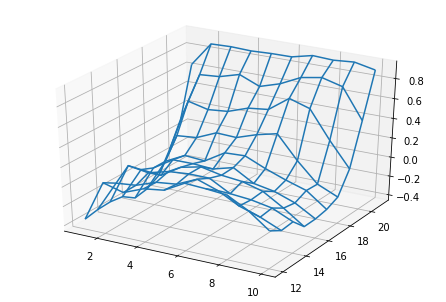

Q-value without Usable Ace


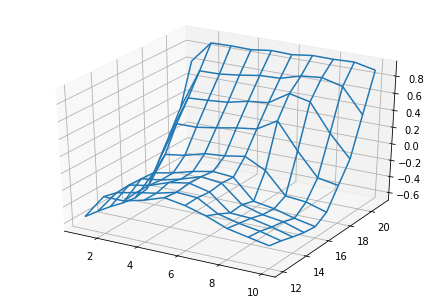

Optimal policy with Usable Ace : (RED : STICK, BLUE : HIT)


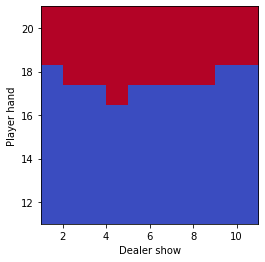

Optimal policy without Usable Ace : (RED : STICK, BLUE : HIT)


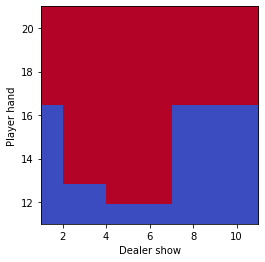

In [8]:
# 학습 결과 시각화
print("Q-value with Usable Ace")
plot_q_val(agent, usable_ace = True)
print("Q-value without Usable Ace")
plot_q_val(agent, usable_ace = False)

print("Optimal policy with Usable Ace : (RED : STICK, BLUE : HIT)")
usable_result = plot_action(agent, usable_ace = True)
print("Optimal policy without Usable Ace : (RED : STICK, BLUE : HIT)")
no_usable_result = plot_action(agent, usable_ace = False)

In [9]:
# 과제 1 : 플레이어와 딜러의 1000번 게임 진행
def play_game(dealer: Dealer, agent: Agent, deck: Deck) :
    
    # 게임 초기화 : 덱, 플레이어, 딜러 상태 초기화 및 딜러와 플레이어는 카드 2장씩 뽑는다.
    deck.reset()
    dealer.reset()
    agent.reset()
    agent.hit(deck)
    agent.hit(deck)
    dealer.hit(deck)
    dealer.hit(deck)

    # 딜러가 공개하는 1장의 카드
    dealer_show = dealer.show() 
    
    # 에피소드 종료 여부 (True : 종료)
    done = False

    episode = list()                         # 에피소드

    while not done:
        # 에피소드가 끝날 때까지 state, action, reward를 생성
        sums = agent.calculate_sum()
        if sums < 12:
            agent.hit(deck)                  # 플레이어는 합계가 12 이상이 될 때 까지 뽑는다.
            continue

        # 플레이어의 합계, 플레이어의 Ace 카드 여부, 딜러가 보여준 카드를 바탕으로 다음 수를 결정
        state = (sums, bool(agent.usable_ace), dealer_show)
        
        # 정의한 state로 추가로 뽑을 것인지를 결정 (이미 결정된 policy를 기반으로 수행한다.)
        action = agent.policy(state)
        
        # 플레이어의 상태에 따라 딜러가 판단을 내림 (에피소드 종료, 혹은 게임 종료 후 reward 계산)
        done, reward = dealer.observation(action, agent, deck)
            
        # 생성된 state, action, reward를 에피소드에 추가 (이번 게임의 진행과 승, 패, 무승부)
        episode.append([state, action, reward])

    return episode

# 결과 집계를 위한 game count, game money 집계
Count_list = list()
Money_list = list()

# 기본 소지금(1만 달러), 승, 패, 무승부 (변수 초기화)
money = 10000
win = 0
loss = 0
draw = 0

# 1000번의 플레이 진행
for i in range(1000):
    
    # 매번 베팅 시 플레이어는 소지금 10달러를 지불
    episode = play_game(dealer, agent, deck)
    money -= 10

    if episode[-1][-1] == 1:        # 승리 : 20달러 획득 (베팅 금액 + 10달러)
        win += 1
        money += 20
    elif episode[-1][-1] == 0:      # 무승부 : 10달러 획득 (베팅 금액)
        draw += 1
        money += 10
    else:                           # 패배 : 소득 X (베팅 금액 손실)
        loss += 1
        
    # 매 게임마다 게임 번호, 소지금 내역을 리스트에 담아 시각화를 준비한다.
    Count_list.append(i + 1)
    Money_list.append(money)

In [10]:
# 과제 2 : 플레이어의 승률 계산
# MonteCarlo의 집계, (과제 1)에서의 출력 형태 참고
print("================= Game play 1000 times  ==================")
print("Player win rate :\t{:.3f}%".format(win / (win + loss) * 100))
print("Win :", win, "\nDraw :", draw, "\nLoss :", loss)

================= Game play 1000 times  ==================
Player win rate :	45.898%
Win : 414 
Draw : 98 
Loss : 488


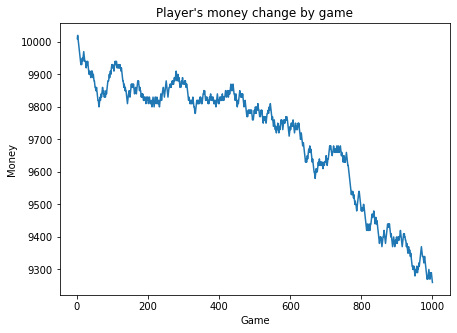

In [11]:
# 과제 3 : 플레이어의 소지금 변화 시각화
plt.figure(figsize = (7, 5))
plt.plot(Count_list, Money_list)
plt.xlabel('Game')
plt.ylabel('Money')
plt.title('Player\'s money change by game')
plt.show()

In [16]:
# 추가 과제 : 플레이어의 승률 높이기
'''
게임 진행방식 변경
- 딜러는 게임이 끝날 때 마다 덱에 남은 카드 수 확인
- 카드 수가 15장 이상이면 해당 덱으로 게임 진행
- 카드 수가 15장 미만이면 다시 52장으로 초기화 후 게임 진행

수정 부분
- Deck : 남은 카드 수 확인할 수 있는 방법 추가
- Dealer : 게임 종료시 덱에 남은 카드 수 확인 후 초기화 여부 결정
- game_play : 수정된 Deck, Dealer의 게임 진행방식 적용
'''

'\n게임 진행방식 변경\n- 딜러는 게임이 끝날 때 마다 덱에 남은 카드 수 확인\n- 카드 수가 15장 이상이면 해당 덱으로 게임 진행\n- 카드 수가 15장 미만이면 다시 52장으로 초기화 후 게임 진행\n\n수정 부분\n- Deck : 남은 카드 수 확인할 수 있는 방법 추가\n- Dealer : 게임 종료시 덱에 남은 카드 수 확인 후 초기화 여부 결정\n- game_play : 수정된 Deck, Dealer의 게임 진행방식 적용\n'

In [12]:
# 카드 덱 클래스
class Deck(object) :
    
    # 생성 시 초기화 함수
    def __init__(self) :
        deck = [2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 11] # 카드는 A, 2, 3, ..., 10, J, Q, K
        self.card_deck = deck * 4                           # 종류는 4개 (스페이드, 클로버, 다이아, 하트)
        self.left_card = 52                                 # 초기 카드 수는 52장
        self.shuffle()                                      # 생성과 동시에 섞는다.
        self.counting = 0
        
    # 덱 셔플
    def shuffle(self):
        random.shuffle(self.card_deck)
        
    # 카드 1장 뽑기
    def draw(self):
        draw_card = self.card_deck.pop()
        self.left_card -= 1                                 # 1장 뽑아갈 때 마다 1씩 감소한다.
        
        if draw_card > 1 and draw_card <= 6 :              # 카드 카운팅 누적계산
            num_score = 1
        elif draw_card > 6 and draw_card <= 9 :
            num_score = 0
        else :
            num_score = -1
        self.counting += num_score                         # 2~6 : +1, 7~9 : 0, 10~11 : -1
        return draw_card
    
    # 카운팅 누적 확인
    def card_counting(self) :
        return self.counting
    
    # 남은 카드 수 확인
    def left_cards(self) :
        return self.left_card                              # 딜러가 확인할 수 있는 잔여 카드 수
    
    # 덱 초기화 (처음 상태로 되돌리기, Init와 같은 내용 수행)
    def reset(self):
        deck = [2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 11]
        self.card_deck = deck * 4
        self.left_card = 52                                 # 카드 수를 52장으로 다시 채워넣는다.
        self.shuffle()
        self.counting = 0

In [13]:
# 딜러 클래스
class Dealer(object) :
    
    # 생성 시 초기화 함수
    def __init__(self) :
        self.hands = list()                                 # 들고 있는 카드 리스트 초기화
        self.usable_ace = list()                           # Ace 존재여부 초기화
        
    # hit : 카드 1장을 뽑는다. 해당 카드가 Ace이면 사용 가능한 Ace 리스트에 추가
    def hit(self, deck: Deck) :
        new_card = deck.draw()                              # 카드 1장 뽑기
        if new_card == 11 :                                   # 해당 카드가 Ace일 경우
            self.usable_ace.append(len(self.hands))           # Ace 인덱스 저장
        self.hands.append(new_card)
        
    # 1장 보여주는 과정
    def show(self) :
        card = random.choice(self.hands)                # 보유한 카드 중 무작위로 1장 선정
        if card == 11 :                                # Ace를 뽑으면 1으로 간주
            card = 1
        return card
    
    # 손에 있는 카드의 합계 계산, Ace가 포함 여부에 따라 연산이 달라진다.
    def calculate_sum(self) :
        sums = sum(self.hands)
        if sums > 21 and len(self.usable_ace) > 0 :  # 합계가 21을 넘는데 Ace가 존재할 경우
            self.hands[self.usable_ace.pop()] = 1     # Ace를 1으로 간주한다.
            sums = sum(self.hands)
        return sums
    
    # 딜러 차례에서의 행동
    def action(self, deck: Deck) :
        while True :
            sums = self.calculate_sum()               # 본인의 합계 집계
            if sums < 17 :                            # 16이하면 한장 더 뽑는다.
                self.hit(deck)
            else :
                return sums                          # 17 이상일 경우 stick(중단, 합계를 반환)
    
    # 플레이어의 Action을 받아 진행할 것인가, 종료할 것인가를 결정하는 함수
    def observation(self, action, agent, deck) :
        done = False
        reward = 0
        if action == True :
            agent.hit(deck)
            if agent.calculate_sum() > 21 :     # 패배 : 플레이어의 총 합이 21을 초과할 경우
                done = True                     # 에피소드 종료 
                reward = -1                     # 마이너스 보상 부여
        else :
            done = True                         # 게임 종료, 점수 및 보상 집계
            reward = self.calculate_reward(agent, deck)
            
        return done, reward
    
    # 점수 집계
    def calculate_reward(self, agent, deck) : 
        agent_sum = agent.calculate_sum()       # 플레이어의 카드 합계
        if agent_sum > 21 :                     # 플레이어의 합계가 21을 초과하면
            return -1                          # Burst (딜러의 점수에 관계없이 패배)
        
        dealer_sum = self.action(deck)          # 딜러의 카드 합계
        if dealer_sum > 21 :                    # 딜러의 총합이 21을 초과하면 플레이어의 승리
            return 1
        if dealer_sum > agent_sum :             # 딜러의 총합이 플레이어보다 크면 딜러의 승리
            return -1
        if dealer_sum < agent_sum :             # 딜러의 총합이 플레이어보다 낮으면 플레이어의 승리
            return 1
        return 0                                # 총합이 동일한 경우 비김, 보상 없음
    
    # 덱을 초기화해야 하는지 체크
    def check_shuffle(self, deck) :
        if deck.left_cards() < 15 :
            return True
        else :
            return False
    
    # 새로운 에피소드를 위한 딜러 초기화
    def reset(self) :
        self.hands = list()
        self.usable_ace = list()

In [14]:
# 플레이어(Agent) 클래스
class Agent(object) :
    
    # 생성 시 초기화 함수
    def __init__(self) :
        self.hands = list()
        self.usable_ace = list()
        self.Q_table = dict()
        
    # hit : 카드 1장을 뽑는다.
    def hit(self, deck: Deck) :
        new_card = deck.draw()
        if new_card == 11 :                          # 뽑은 카드가 Ace 일 경우, Ace의 인덱스 저장
            self.usable_ace.append(len(self.hands))
        self.hands.append(new_card)
    
    # 손에 있는 카드의 합계 계산, Ace가 포함 여부에 따라 연산이 달라진다.
    def calculate_sum(self) :
        sums = sum(self.hands)
        if sums > 21 and len(self.usable_ace) > 0 :  # 합계가 21을 넘는데 Ace가 존재할 경우
            self.hands[self.usable_ace.pop()] = 1     # Ace를 1으로 간주 (합계를 21 이하로 낮춤)
            sums = sum(self.hands)
        return sums
    
    # 플레이어의 다음 행동을 무작위로 선정 (True : hit, False : stick)
    def random_action(self) :
        return random.choice([True, False])
    
    # Policy 함수
    def policy(self, state) :
        
        # Q_table에서 현재 state-action에 대해 값이 존재하는지 검사
        for action in (True, False) :
            if (state, action) not in self.Q_table.keys() :   # 없으면
                self.Q_table[(state, action)] = [0, 0, 0]         # 0으로 초기화
            else :
                continue
        
        # Q 값이 큰 action을 선택
        if self.Q_table[(state, True)] > self.Q_table[(state, False)] :
            return True
        elif self.Q_table[(state, True)] == self.Q_table[(state, False)] :
            return self.random_action()                       # 값이 동일하면 무작위 선택
        else :
            return False
        
    
    # 새로운 에피소드를 위한 플레이어 초기화 (평가지표인 Q_table은 초기화하지 않음)
    def reset(self) :
        self.hands = list()
        self.usable_ace = list()
    
    # 에피소드(게임 진행과정)으로부터 Q_table을 업데이트, 
    def update_qval(self, episode, counting) : 
        total_return = 0
        for state, action, reward in episode[:: -1] :   # 뒤에서부터 확인 (역순으로)
            total_return += reward
            if(state, action) not in self.Q_table.keys() :         # state-action 쌍이 없으면
                self.Q_table[(state, action)] = [total_return, 1]       # 새로운 엔트리 생성
            else :                                                 # state-action 쌍이 존재하면
                prev_val = self.Q_table[(state, action)][0]             # 이전의 평균
                count = self.Q_table[(state, action)][1] + 1            # count 증가
                mean = prev_val + (total_return - prev_val) / count    # 새로 평균 계산
                self.Q_table[(state, action)] = [mean, count]           # 이것으로 업데이트

In [15]:
class MonteCarlo_renew(object) :
    def generate_episode(self, dealer: Dealer, agent: Agent, deck: Deck, cardcounting) :
        
        dealer.reset()
        agent.reset()
        agent.hit(deck)
        agent.hit(deck)
        dealer.hit(deck)
        dealer.hit(deck)
        
        # 딜러가 공개하는 1장의 카드
        dealer_show = dealer.show()
        
        # 에피소드 종료 여부
        done = False
        
        # 에피소드 순서
        episode = list()
        
        counting =  cardcounting

        while not done :
            
            # 에피소드가 종료될 때 까지 state, action, reward를 생성
            sums = agent.calculate_sum()
            
            # agent : 합계가 12 이상이 될 때 까지 hit
            if sums < 12 :
                agent.hit(deck)
                continue
            
            # state 생성
            state = (sums, bool(agent.usable_ace), dealer_show, counting)
            
            # action 생성 (에피소드가 없으면 무작위로 생성, 있으면 state에 따른 행동 수행)
            if len(episode) == 0 :
                action = agent.random_action()
            else :
                action = agent.policy(state)
            
            # agent의 행동 관찰을 바탕으로 dealer가 행위를 결정 (done - False : 끝나지 않음, True : 끝남)
            done, reward = dealer.observation(action, agent, deck)
            
            # 에피소드에 추가
            episode.append([state, action, reward])
        
        if dealer.check_shuffle(deck) :
            deck.reset()
        return episode
    
    # 에피소드를 생성, 딜러와 플레이어가 겨뤄 플레이어의 학습 진행
    def train(self, dealer: Dealer, agent: Agent, deck: Deck, it = 10000, verbose = True) :
        count = 0
        win = 0
        loss = 0
        draw = 0
        total_win = 0
        total_loss = 0
        total_draw = 0
        
        # 1000번 단위로 플레이 집계
        for i in range(it) :
            count += 1
            counting = deck.card_counting()
            episode = self.generate_episode(dealer, agent, deck, counting)
            agent.update_qval(episode, counting)
            
            # 승, 패, 무승부 집계
            if episode[-1][-1] == 1 :
                win += 1
            elif episode[-1][-1] == 0 :
                draw += 1
            else :
                loss += 1
                
            if count % 1000 == 0 and verbose == True :
                # 1000번 수행의 승, 패, 무승부를 누적 전적에 집계
                total_win += win
                total_draw += draw
                total_loss += loss
                
                # 이번 차례의 1000번 수행의 결과, 누적 전적 결과 집계
                print("========== Training : Episode ", count, " ===========")
                print("Recent 1000 games win rate :{:.3f}%".format(win / (win + loss) * 100))
                print(" -- 1000 Games WIN :", win, "DRAW :", draw, "LOSS :", loss)
                print("Total win rate : {:.3f}%".format(total_win / (total_win + total_loss) * 100))
                print(" -- TOTAL Games WIN :", total_win, "DRAW :", total_draw, "LOSS :", total_loss, "\n")
                
                # 다시 1000번 수행을 위해 초기화
                win = 0
                loss = 0
                draw = 0

In [16]:
# 변경된 방식으로 최적 Policy 학습
deck_renew = Deck()
dealer_renew = Dealer()
agent_renew = Agent()
mc_es_r = MonteCarlo_renew()

mc_es_r.train(dealer_renew, agent_renew, deck_renew, it = 1000000)   # 100만번 학습 수행

========== Training : Episode  1000  ===========
Recent 1000 games win rate :32.770%
 -- 1000 Games WIN : 310 DRAW : 54 LOSS : 636
Total win rate : 32.770%
 -- TOTAL Games WIN : 310 DRAW : 54 LOSS : 636 

========== Training : Episode  2000  ===========
Recent 1000 games win rate :29.787%
 -- 1000 Games WIN : 280 DRAW : 60 LOSS : 660
Total win rate : 31.283%
 -- TOTAL Games WIN : 590 DRAW : 114 LOSS : 1296 

========== Training : Episode  3000  ===========
Recent 1000 games win rate :32.593%
 -- 1000 Games WIN : 308 DRAW : 55 LOSS : 637
Total win rate : 31.720%
 -- TOTAL Games WIN : 898 DRAW : 169 LOSS : 1933 

========== Training : Episode  4000  ===========
Recent 1000 games win rate :35.508%
 -- 1000 Games WIN : 332 DRAW : 65 LOSS : 603
Total win rate : 32.661%
 -- TOTAL Games WIN : 1230 DRAW : 234 LOSS : 2536 

========== Training : Episode  5000  ===========
Recent 1000 games win rate :32.521%
 -- 1000 Games WIN : 307 DRAW : 56 LOSS : 637
Total win rate : 32.633%
 -- TOTAL Games W

========== Training : Episode  46000  ===========
Recent 1000 games win rate :35.288%
 -- 1000 Games WIN : 331 DRAW : 62 LOSS : 607
Total win rate : 34.183%
 -- TOTAL Games WIN : 14805 DRAW : 2689 LOSS : 28506 

========== Training : Episode  47000  ===========
Recent 1000 games win rate :35.244%
 -- 1000 Games WIN : 332 DRAW : 58 LOSS : 610
Total win rate : 34.206%
 -- TOTAL Games WIN : 15137 DRAW : 2747 LOSS : 29116 

========== Training : Episode  48000  ===========
Recent 1000 games win rate :34.727%
 -- 1000 Games WIN : 324 DRAW : 67 LOSS : 609
Total win rate : 34.216%
 -- TOTAL Games WIN : 15461 DRAW : 2814 LOSS : 29725 

========== Training : Episode  49000  ===========
Recent 1000 games win rate :37.754%
 -- 1000 Games WIN : 353 DRAW : 65 LOSS : 582
Total win rate : 34.288%
 -- TOTAL Games WIN : 15814 DRAW : 2879 LOSS : 30307 

========== Training : Episode  50000  ===========
Recent 1000 games win rate :35.729%
 -- 1000 Games WIN : 338 DRAW : 54 LOSS : 608
Total win rate : 34.

========== Training : Episode  88000  ===========
Recent 1000 games win rate :34.713%
 -- 1000 Games WIN : 327 DRAW : 58 LOSS : 615
Total win rate : 34.614%
 -- TOTAL Games WIN : 28660 DRAW : 5202 LOSS : 54138 

========== Training : Episode  89000  ===========
Recent 1000 games win rate :34.661%
 -- 1000 Games WIN : 322 DRAW : 71 LOSS : 607
Total win rate : 34.615%
 -- TOTAL Games WIN : 28982 DRAW : 5273 LOSS : 54745 

========== Training : Episode  90000  ===========
Recent 1000 games win rate :34.839%
 -- 1000 Games WIN : 324 DRAW : 70 LOSS : 606
Total win rate : 34.617%
 -- TOTAL Games WIN : 29306 DRAW : 5343 LOSS : 55351 

========== Training : Episode  91000  ===========
Recent 1000 games win rate :37.025%
 -- 1000 Games WIN : 351 DRAW : 52 LOSS : 597
Total win rate : 34.644%
 -- TOTAL Games WIN : 29657 DRAW : 5395 LOSS : 55948 

========== Training : Episode  92000  ===========
Recent 1000 games win rate :34.611%
 -- 1000 Games WIN : 325 DRAW : 61 LOSS : 614
Total win rate : 34.

========== Training : Episode  129000  ===========
Recent 1000 games win rate :36.181%
 -- 1000 Games WIN : 343 DRAW : 52 LOSS : 605
Total win rate : 34.793%
 -- TOTAL Games WIN : 42231 DRAW : 7622 LOSS : 79147 

========== Training : Episode  130000  ===========
Recent 1000 games win rate :36.207%
 -- 1000 Games WIN : 336 DRAW : 72 LOSS : 592
Total win rate : 34.804%
 -- TOTAL Games WIN : 42567 DRAW : 7694 LOSS : 79739 

========== Training : Episode  131000  ===========
Recent 1000 games win rate :33.477%
 -- 1000 Games WIN : 311 DRAW : 71 LOSS : 618
Total win rate : 34.794%
 -- TOTAL Games WIN : 42878 DRAW : 7765 LOSS : 80357 

========== Training : Episode  132000  ===========
Recent 1000 games win rate :34.113%
 -- 1000 Games WIN : 321 DRAW : 59 LOSS : 620
Total win rate : 34.789%
 -- TOTAL Games WIN : 43199 DRAW : 7824 LOSS : 80977 

========== Training : Episode  133000  ===========
Recent 1000 games win rate :36.450%
 -- 1000 Games WIN : 347 DRAW : 48 LOSS : 605
Total win rate 

========== Training : Episode  168000  ===========
Recent 1000 games win rate :34.277%
 -- 1000 Games WIN : 327 DRAW : 46 LOSS : 627
Total win rate : 34.915%
 -- TOTAL Games WIN : 55189 DRAW : 9934 LOSS : 102877 

========== Training : Episode  169000  ===========
Recent 1000 games win rate :37.953%
 -- 1000 Games WIN : 356 DRAW : 62 LOSS : 582
Total win rate : 34.933%
 -- TOTAL Games WIN : 55545 DRAW : 9996 LOSS : 103459 

========== Training : Episode  170000  ===========
Recent 1000 games win rate :35.112%
 -- 1000 Games WIN : 329 DRAW : 63 LOSS : 608
Total win rate : 34.934%
 -- TOTAL Games WIN : 55874 DRAW : 10059 LOSS : 104067 

========== Training : Episode  171000  ===========
Recent 1000 games win rate :37.738%
 -- 1000 Games WIN : 357 DRAW : 54 LOSS : 589
Total win rate : 34.951%
 -- TOTAL Games WIN : 56231 DRAW : 10113 LOSS : 104656 

========== Training : Episode  172000  ===========
Recent 1000 games win rate :32.166%
 -- 1000 Games WIN : 303 DRAW : 58 LOSS : 639
Total win

========== Training : Episode  212000  ===========
Recent 1000 games win rate :34.490%
 -- 1000 Games WIN : 328 DRAW : 49 LOSS : 623
Total win rate : 35.026%
 -- TOTAL Games WIN : 69869 DRAW : 12525 LOSS : 129606 

========== Training : Episode  213000  ===========
Recent 1000 games win rate :34.847%
 -- 1000 Games WIN : 330 DRAW : 53 LOSS : 617
Total win rate : 35.026%
 -- TOTAL Games WIN : 70199 DRAW : 12578 LOSS : 130223 

========== Training : Episode  214000  ===========
Recent 1000 games win rate :34.375%
 -- 1000 Games WIN : 319 DRAW : 72 LOSS : 609
Total win rate : 35.023%
 -- TOTAL Games WIN : 70518 DRAW : 12650 LOSS : 130832 

========== Training : Episode  215000  ===========
Recent 1000 games win rate :36.541%
 -- 1000 Games WIN : 338 DRAW : 75 LOSS : 587
Total win rate : 35.030%
 -- TOTAL Games WIN : 70856 DRAW : 12725 LOSS : 131419 

========== Training : Episode  216000  ===========
Recent 1000 games win rate :36.093%
 -- 1000 Games WIN : 340 DRAW : 58 LOSS : 602
Total w

========== Training : Episode  255000  ===========
Recent 1000 games win rate :34.067%
 -- 1000 Games WIN : 325 DRAW : 46 LOSS : 629
Total win rate : 35.088%
 -- TOTAL Games WIN : 84188 DRAW : 15064 LOSS : 155748 

========== Training : Episode  256000  ===========
Recent 1000 games win rate :36.030%
 -- 1000 Games WIN : 334 DRAW : 73 LOSS : 593
Total win rate : 35.091%
 -- TOTAL Games WIN : 84522 DRAW : 15137 LOSS : 156341 

========== Training : Episode  257000  ===========
Recent 1000 games win rate :37.869%
 -- 1000 Games WIN : 359 DRAW : 52 LOSS : 589
Total win rate : 35.102%
 -- TOTAL Games WIN : 84881 DRAW : 15189 LOSS : 156930 

========== Training : Episode  258000  ===========
Recent 1000 games win rate :33.439%
 -- 1000 Games WIN : 316 DRAW : 55 LOSS : 629
Total win rate : 35.096%
 -- TOTAL Games WIN : 85197 DRAW : 15244 LOSS : 157559 

========== Training : Episode  259000  ===========
Recent 1000 games win rate :37.057%
 -- 1000 Games WIN : 345 DRAW : 69 LOSS : 586
Total w

========== Training : Episode  300000  ===========
Recent 1000 games win rate :38.665%
 -- 1000 Games WIN : 365 DRAW : 56 LOSS : 579
Total win rate : 35.101%
 -- TOTAL Games WIN : 99080 DRAW : 17730 LOSS : 183190 

========== Training : Episode  301000  ===========
Recent 1000 games win rate :33.873%
 -- 1000 Games WIN : 314 DRAW : 73 LOSS : 613
Total win rate : 35.097%
 -- TOTAL Games WIN : 99394 DRAW : 17803 LOSS : 183803 

========== Training : Episode  302000  ===========
Recent 1000 games win rate :35.213%
 -- 1000 Games WIN : 331 DRAW : 60 LOSS : 609
Total win rate : 35.098%
 -- TOTAL Games WIN : 99725 DRAW : 17863 LOSS : 184412 

========== Training : Episode  303000  ===========
Recent 1000 games win rate :34.632%
 -- 1000 Games WIN : 320 DRAW : 76 LOSS : 604
Total win rate : 35.096%
 -- TOTAL Games WIN : 100045 DRAW : 17939 LOSS : 185016 

========== Training : Episode  304000  ===========
Recent 1000 games win rate :33.051%
 -- 1000 Games WIN : 312 DRAW : 56 LOSS : 632
Total 

========== Training : Episode  339000  ===========
Recent 1000 games win rate :35.300%
 -- 1000 Games WIN : 335 DRAW : 51 LOSS : 614
Total win rate : 35.135%
 -- TOTAL Games WIN : 112052 DRAW : 20084 LOSS : 206864 

========== Training : Episode  340000  ===========
Recent 1000 games win rate :34.249%
 -- 1000 Games WIN : 324 DRAW : 54 LOSS : 622
Total win rate : 35.133%
 -- TOTAL Games WIN : 112376 DRAW : 20138 LOSS : 207486 

========== Training : Episode  341000  ===========
Recent 1000 games win rate :34.325%
 -- 1000 Games WIN : 323 DRAW : 59 LOSS : 618
Total win rate : 35.130%
 -- TOTAL Games WIN : 112699 DRAW : 20197 LOSS : 208104 

========== Training : Episode  342000  ===========
Recent 1000 games win rate :35.532%
 -- 1000 Games WIN : 334 DRAW : 60 LOSS : 606
Total win rate : 35.131%
 -- TOTAL Games WIN : 113033 DRAW : 20257 LOSS : 208710 

========== Training : Episode  343000  ===========
Recent 1000 games win rate :35.463%
 -- 1000 Games WIN : 333 DRAW : 61 LOSS : 606
Tot

========== Training : Episode  381000  ===========
Recent 1000 games win rate :37.064%
 -- 1000 Games WIN : 351 DRAW : 53 LOSS : 596
Total win rate : 35.166%
 -- TOTAL Games WIN : 126069 DRAW : 22504 LOSS : 232427 

========== Training : Episode  382000  ===========
Recent 1000 games win rate :33.580%
 -- 1000 Games WIN : 318 DRAW : 53 LOSS : 629
Total win rate : 35.162%
 -- TOTAL Games WIN : 126387 DRAW : 22557 LOSS : 233056 

========== Training : Episode  383000  ===========
Recent 1000 games win rate :36.296%
 -- 1000 Games WIN : 339 DRAW : 66 LOSS : 595
Total win rate : 35.165%
 -- TOTAL Games WIN : 126726 DRAW : 22623 LOSS : 233651 

========== Training : Episode  384000  ===========
Recent 1000 games win rate :35.326%
 -- 1000 Games WIN : 331 DRAW : 63 LOSS : 606
Total win rate : 35.165%
 -- TOTAL Games WIN : 127057 DRAW : 22686 LOSS : 234257 

========== Training : Episode  385000  ===========
Recent 1000 games win rate :36.663%
 -- 1000 Games WIN : 345 DRAW : 59 LOSS : 596
Tot

========== Training : Episode  429000  ===========
Recent 1000 games win rate :37.960%
 -- 1000 Games WIN : 361 DRAW : 49 LOSS : 590
Total win rate : 35.208%
 -- TOTAL Games WIN : 142126 DRAW : 25330 LOSS : 261544 

========== Training : Episode  430000  ===========
Recent 1000 games win rate :34.354%
 -- 1000 Games WIN : 314 DRAW : 86 LOSS : 600
Total win rate : 35.207%
 -- TOTAL Games WIN : 142440 DRAW : 25416 LOSS : 262144 

========== Training : Episode  431000  ===========
Recent 1000 games win rate :34.319%
 -- 1000 Games WIN : 325 DRAW : 53 LOSS : 622
Total win rate : 35.204%
 -- TOTAL Games WIN : 142765 DRAW : 25469 LOSS : 262766 

========== Training : Episode  432000  ===========
Recent 1000 games win rate :33.122%
 -- 1000 Games WIN : 313 DRAW : 55 LOSS : 632
Total win rate : 35.200%
 -- TOTAL Games WIN : 143078 DRAW : 25524 LOSS : 263398 

========== Training : Episode  433000  ===========
Recent 1000 games win rate :36.043%
 -- 1000 Games WIN : 337 DRAW : 65 LOSS : 598
Tot

========== Training : Episode  469000  ===========
Recent 1000 games win rate :35.729%
 -- 1000 Games WIN : 338 DRAW : 54 LOSS : 608
Total win rate : 35.220%
 -- TOTAL Games WIN : 155392 DRAW : 27794 LOSS : 285814 

========== Training : Episode  470000  ===========
Recent 1000 games win rate :35.026%
 -- 1000 Games WIN : 331 DRAW : 55 LOSS : 614
Total win rate : 35.219%
 -- TOTAL Games WIN : 155723 DRAW : 27849 LOSS : 286428 

========== Training : Episode  471000  ===========
Recent 1000 games win rate :34.750%
 -- 1000 Games WIN : 327 DRAW : 59 LOSS : 614
Total win rate : 35.218%
 -- TOTAL Games WIN : 156050 DRAW : 27908 LOSS : 287042 

========== Training : Episode  472000  ===========
Recent 1000 games win rate :34.439%
 -- 1000 Games WIN : 322 DRAW : 65 LOSS : 613
Total win rate : 35.217%
 -- TOTAL Games WIN : 156372 DRAW : 27973 LOSS : 287655 

========== Training : Episode  473000  ===========
Recent 1000 games win rate :34.424%
 -- 1000 Games WIN : 326 DRAW : 53 LOSS : 621
Tot

========== Training : Episode  508000  ===========
Recent 1000 games win rate :34.636%
 -- 1000 Games WIN : 328 DRAW : 53 LOSS : 619
Total win rate : 35.219%
 -- TOTAL Games WIN : 168314 DRAW : 30089 LOSS : 309597 

========== Training : Episode  509000  ===========
Recent 1000 games win rate :36.479%
 -- 1000 Games WIN : 344 DRAW : 57 LOSS : 599
Total win rate : 35.221%
 -- TOTAL Games WIN : 168658 DRAW : 30146 LOSS : 310196 

========== Training : Episode  510000  ===========
Recent 1000 games win rate :31.987%
 -- 1000 Games WIN : 301 DRAW : 59 LOSS : 640
Total win rate : 35.215%
 -- TOTAL Games WIN : 168959 DRAW : 30205 LOSS : 310836 

========== Training : Episode  511000  ===========
Recent 1000 games win rate :35.141%
 -- 1000 Games WIN : 324 DRAW : 78 LOSS : 598
Total win rate : 35.215%
 -- TOTAL Games WIN : 169283 DRAW : 30283 LOSS : 311434 

========== Training : Episode  512000  ===========
Recent 1000 games win rate :35.394%
 -- 1000 Games WIN : 332 DRAW : 62 LOSS : 606
Tot

========== Training : Episode  548000  ===========
Recent 1000 games win rate :39.236%
 -- 1000 Games WIN : 370 DRAW : 57 LOSS : 573
Total win rate : 35.242%
 -- TOTAL Games WIN : 181668 DRAW : 32520 LOSS : 333812 

========== Training : Episode  549000  ===========
Recent 1000 games win rate :37.701%
 -- 1000 Games WIN : 351 DRAW : 69 LOSS : 580
Total win rate : 35.247%
 -- TOTAL Games WIN : 182019 DRAW : 32589 LOSS : 334392 

========== Training : Episode  550000  ===========
Recent 1000 games win rate :36.402%
 -- 1000 Games WIN : 344 DRAW : 55 LOSS : 601
Total win rate : 35.249%
 -- TOTAL Games WIN : 182363 DRAW : 32644 LOSS : 334993 

========== Training : Episode  551000  ===========
Recent 1000 games win rate :34.876%
 -- 1000 Games WIN : 324 DRAW : 71 LOSS : 605
Total win rate : 35.248%
 -- TOTAL Games WIN : 182687 DRAW : 32715 LOSS : 335598 

========== Training : Episode  552000  ===========
Recent 1000 games win rate :35.043%
 -- 1000 Games WIN : 328 DRAW : 64 LOSS : 608
Tot

 -- TOTAL Games WIN : 194745 DRAW : 34921 LOSS : 358334 

========== Training : Episode  589000  ===========
Recent 1000 games win rate :33.836%
 -- 1000 Games WIN : 314 DRAW : 72 LOSS : 614
Total win rate : 35.209%
 -- TOTAL Games WIN : 195059 DRAW : 34993 LOSS : 358948 

========== Training : Episode  590000  ===========
Recent 1000 games win rate :36.998%
 -- 1000 Games WIN : 350 DRAW : 54 LOSS : 596
Total win rate : 35.212%
 -- TOTAL Games WIN : 195409 DRAW : 35047 LOSS : 359544 

========== Training : Episode  591000  ===========
Recent 1000 games win rate :34.963%
 -- 1000 Games WIN : 329 DRAW : 59 LOSS : 612
Total win rate : 35.211%
 -- TOTAL Games WIN : 195738 DRAW : 35106 LOSS : 360156 

========== Training : Episode  592000  ===========
Recent 1000 games win rate :34.759%
 -- 1000 Games WIN : 325 DRAW : 65 LOSS : 610
Total win rate : 35.211%
 -- TOTAL Games WIN : 196063 DRAW : 35171 LOSS : 360766 

========== Training : Episode  593000  ===========
Recent 1000 games win rate 

========== Training : Episode  636000  ===========
Recent 1000 games win rate :33.014%
 -- 1000 Games WIN : 310 DRAW : 61 LOSS : 629
Total win rate : 35.249%
 -- TOTAL Games WIN : 210852 DRAW : 37816 LOSS : 387332 

========== Training : Episode  637000  ===========
Recent 1000 games win rate :34.144%
 -- 1000 Games WIN : 323 DRAW : 54 LOSS : 623
Total win rate : 35.247%
 -- TOTAL Games WIN : 211175 DRAW : 37870 LOSS : 387955 

========== Training : Episode  638000  ===========
Recent 1000 games win rate :37.100%
 -- 1000 Games WIN : 348 DRAW : 62 LOSS : 590
Total win rate : 35.250%
 -- TOTAL Games WIN : 211523 DRAW : 37932 LOSS : 388545 

========== Training : Episode  639000  ===========
Recent 1000 games win rate :37.527%
 -- 1000 Games WIN : 352 DRAW : 62 LOSS : 586
Total win rate : 35.253%
 -- TOTAL Games WIN : 211875 DRAW : 37994 LOSS : 389131 

========== Training : Episode  640000  ===========
Recent 1000 games win rate :37.792%
 -- 1000 Games WIN : 356 DRAW : 58 LOSS : 586
Tot

 -- 1000 Games WIN : 337 DRAW : 61 LOSS : 602
Total win rate : 35.268%
 -- TOTAL Games WIN : 224560 DRAW : 40276 LOSS : 412164 

========== Training : Episode  678000  ===========
Recent 1000 games win rate :33.862%
 -- 1000 Games WIN : 320 DRAW : 55 LOSS : 625
Total win rate : 35.266%
 -- TOTAL Games WIN : 224880 DRAW : 40331 LOSS : 412789 

========== Training : Episode  679000  ===========
Recent 1000 games win rate :33.158%
 -- 1000 Games WIN : 316 DRAW : 47 LOSS : 637
Total win rate : 35.263%
 -- TOTAL Games WIN : 225196 DRAW : 40378 LOSS : 413426 

========== Training : Episode  680000  ===========
Recent 1000 games win rate :36.209%
 -- 1000 Games WIN : 340 DRAW : 61 LOSS : 599
Total win rate : 35.264%
 -- TOTAL Games WIN : 225536 DRAW : 40439 LOSS : 414025 

========== Training : Episode  681000  ===========
Recent 1000 games win rate :32.588%
 -- 1000 Games WIN : 306 DRAW : 61 LOSS : 633
Total win rate : 35.260%
 -- TOTAL Games WIN : 225842 DRAW : 40500 LOSS : 414658 

=======

========== Training : Episode  724000  ===========
Recent 1000 games win rate :36.741%
 -- 1000 Games WIN : 345 DRAW : 61 LOSS : 594
Total win rate : 35.293%
 -- TOTAL Games WIN : 240313 DRAW : 43097 LOSS : 440590 

========== Training : Episode  725000  ===========
Recent 1000 games win rate :35.086%
 -- 1000 Games WIN : 327 DRAW : 68 LOSS : 605
Total win rate : 35.293%
 -- TOTAL Games WIN : 240640 DRAW : 43165 LOSS : 441195 

========== Training : Episode  726000  ===========
Recent 1000 games win rate :36.038%
 -- 1000 Games WIN : 342 DRAW : 51 LOSS : 607
Total win rate : 35.294%
 -- TOTAL Games WIN : 240982 DRAW : 43216 LOSS : 441802 

========== Training : Episode  727000  ===========
Recent 1000 games win rate :34.412%
 -- 1000 Games WIN : 319 DRAW : 73 LOSS : 608
Total win rate : 35.293%
 -- TOTAL Games WIN : 241301 DRAW : 43289 LOSS : 442410 

========== Training : Episode  728000  ===========
Recent 1000 games win rate :36.617%
 -- 1000 Games WIN : 342 DRAW : 66 LOSS : 592
Tot

========== Training : Episode  771000  ===========
Recent 1000 games win rate :34.328%
 -- 1000 Games WIN : 322 DRAW : 62 LOSS : 616
Total win rate : 35.306%
 -- TOTAL Games WIN : 256005 DRAW : 45898 LOSS : 469097 

========== Training : Episode  772000  ===========
Recent 1000 games win rate :36.870%
 -- 1000 Games WIN : 344 DRAW : 67 LOSS : 589
Total win rate : 35.308%
 -- TOTAL Games WIN : 256349 DRAW : 45965 LOSS : 469686 

========== Training : Episode  773000  ===========
Recent 1000 games win rate :33.404%
 -- 1000 Games WIN : 317 DRAW : 51 LOSS : 632
Total win rate : 35.306%
 -- TOTAL Games WIN : 256666 DRAW : 46016 LOSS : 470318 

========== Training : Episode  774000  ===========
Recent 1000 games win rate :35.467%
 -- 1000 Games WIN : 338 DRAW : 47 LOSS : 615
Total win rate : 35.306%
 -- TOTAL Games WIN : 257004 DRAW : 46063 LOSS : 470933 

========== Training : Episode  775000  ===========
Recent 1000 games win rate :34.652%
 -- 1000 Games WIN : 324 DRAW : 65 LOSS : 611
Tot

========== Training : Episode  811000  ===========
Recent 1000 games win rate :36.943%
 -- 1000 Games WIN : 348 DRAW : 58 LOSS : 594
Total win rate : 35.301%
 -- TOTAL Games WIN : 269248 DRAW : 48288 LOSS : 493464 

========== Training : Episode  812000  ===========
Recent 1000 games win rate :38.593%
 -- 1000 Games WIN : 362 DRAW : 62 LOSS : 576
Total win rate : 35.305%
 -- TOTAL Games WIN : 269610 DRAW : 48350 LOSS : 494040 

========== Training : Episode  813000  ===========
Recent 1000 games win rate :35.897%
 -- 1000 Games WIN : 336 DRAW : 64 LOSS : 600
Total win rate : 35.306%
 -- TOTAL Games WIN : 269946 DRAW : 48414 LOSS : 494640 

========== Training : Episode  814000  ===========
Recent 1000 games win rate :35.692%
 -- 1000 Games WIN : 338 DRAW : 53 LOSS : 609
Total win rate : 35.307%
 -- TOTAL Games WIN : 270284 DRAW : 48467 LOSS : 495249 

========== Training : Episode  815000  ===========
Recent 1000 games win rate :36.373%
 -- 1000 Games WIN : 343 DRAW : 57 LOSS : 600
Tot

========== Training : Episode  850000  ===========
Recent 1000 games win rate :36.451%
 -- 1000 Games WIN : 343 DRAW : 59 LOSS : 598
Total win rate : 35.303%
 -- TOTAL Games WIN : 282228 DRAW : 50565 LOSS : 517207 

========== Training : Episode  851000  ===========
Recent 1000 games win rate :35.752%
 -- 1000 Games WIN : 335 DRAW : 63 LOSS : 602
Total win rate : 35.304%
 -- TOTAL Games WIN : 282563 DRAW : 50628 LOSS : 517809 

========== Training : Episode  852000  ===========
Recent 1000 games win rate :33.191%
 -- 1000 Games WIN : 311 DRAW : 63 LOSS : 626
Total win rate : 35.301%
 -- TOTAL Games WIN : 282874 DRAW : 50691 LOSS : 518435 

========== Training : Episode  853000  ===========
Recent 1000 games win rate :35.349%
 -- 1000 Games WIN : 339 DRAW : 41 LOSS : 620
Total win rate : 35.302%
 -- TOTAL Games WIN : 283213 DRAW : 50732 LOSS : 519055 

========== Training : Episode  854000  ===========
Recent 1000 games win rate :37.433%
 -- 1000 Games WIN : 350 DRAW : 65 LOSS : 585
Tot

========== Training : Episode  889000  ===========
Recent 1000 games win rate :33.794%
 -- 1000 Games WIN : 318 DRAW : 59 LOSS : 623
Total win rate : 35.313%
 -- TOTAL Games WIN : 295268 DRAW : 52857 LOSS : 540875 

========== Training : Episode  890000  ===========
Recent 1000 games win rate :34.289%
 -- 1000 Games WIN : 323 DRAW : 58 LOSS : 619
Total win rate : 35.312%
 -- TOTAL Games WIN : 295591 DRAW : 52915 LOSS : 541494 

========== Training : Episode  891000  ===========
Recent 1000 games win rate :37.895%
 -- 1000 Games WIN : 360 DRAW : 50 LOSS : 590
Total win rate : 35.315%
 -- TOTAL Games WIN : 295951 DRAW : 52965 LOSS : 542084 

========== Training : Episode  892000  ===========
Recent 1000 games win rate :34.889%
 -- 1000 Games WIN : 329 DRAW : 57 LOSS : 614
Total win rate : 35.314%
 -- TOTAL Games WIN : 296280 DRAW : 53022 LOSS : 542698 

========== Training : Episode  893000  ===========
Recent 1000 games win rate :33.929%
 -- 1000 Games WIN : 323 DRAW : 48 LOSS : 629
Tot

========== Training : Episode  936000  ===========
Recent 1000 games win rate :35.263%
 -- 1000 Games WIN : 329 DRAW : 67 LOSS : 604
Total win rate : 35.311%
 -- TOTAL Games WIN : 310849 DRAW : 55678 LOSS : 569473 

========== Training : Episode  937000  ===========
Recent 1000 games win rate :38.203%
 -- 1000 Games WIN : 353 DRAW : 76 LOSS : 571
Total win rate : 35.314%
 -- TOTAL Games WIN : 311202 DRAW : 55754 LOSS : 570044 

========== Training : Episode  938000  ===========
Recent 1000 games win rate :35.608%
 -- 1000 Games WIN : 334 DRAW : 62 LOSS : 604
Total win rate : 35.314%
 -- TOTAL Games WIN : 311536 DRAW : 55816 LOSS : 570648 

========== Training : Episode  939000  ===========
Recent 1000 games win rate :35.699%
 -- 1000 Games WIN : 337 DRAW : 56 LOSS : 607
Total win rate : 35.315%
 -- TOTAL Games WIN : 311873 DRAW : 55872 LOSS : 571255 

========== Training : Episode  940000  ===========
Recent 1000 games win rate :36.008%
 -- 1000 Games WIN : 341 DRAW : 53 LOSS : 606
Tot

========== Training : Episode  974000  ===========
Recent 1000 games win rate :36.373%
 -- 1000 Games WIN : 343 DRAW : 57 LOSS : 600
Total win rate : 35.309%
 -- TOTAL Games WIN : 323406 DRAW : 58059 LOSS : 592535 

========== Training : Episode  975000  ===========
Recent 1000 games win rate :33.050%
 -- 1000 Games WIN : 311 DRAW : 59 LOSS : 630
Total win rate : 35.306%
 -- TOTAL Games WIN : 323717 DRAW : 58118 LOSS : 593165 

========== Training : Episode  976000  ===========
Recent 1000 games win rate :35.511%
 -- 1000 Games WIN : 337 DRAW : 51 LOSS : 612
Total win rate : 35.306%
 -- TOTAL Games WIN : 324054 DRAW : 58169 LOSS : 593777 

========== Training : Episode  977000  ===========
Recent 1000 games win rate :37.527%
 -- 1000 Games WIN : 352 DRAW : 62 LOSS : 586
Total win rate : 35.309%
 -- TOTAL Games WIN : 324406 DRAW : 58231 LOSS : 594363 

========== Training : Episode  978000  ===========
Recent 1000 games win rate :36.093%
 -- 1000 Games WIN : 340 DRAW : 58 LOSS : 602
Tot

In [17]:
# Q값 시각화 함수
def plot_q_val(agent: Agent, usable_ace = True):
    fig = plt.figure()
    ax = Axes3D(fig)

    hands = set()
    dealer_show = set()

    for state in sorted(agent.Q_table.keys()):
        hands.add(state[0])
        dealer_show.add(state[2])

    Z_list = list()
    l = list()

    for d in dealer_show:
        l = []
        for hand in hands:
            if ((hand, usable_ace, d), True, counting) not in agent.Q_table.keys():
                agent.Q_table[((hand, usable_ace, d), True)] = [0, 0]
            if ((hand, usable_ace, d), False, counting) not in agent.Q_table.keys():
                agent.Q_table[((hand, usable_ace, d), False)] = [0, 0]
            v_val = max([agent.Q_table[((hand, usable_ace, d), True)][0], agent.Q_table[((hand, usable_ace, d), False)][0]])
            l.append(v_val)
        Z_list.append(l)

    Y = np.array(list(hands))
    X = np.array(list(dealer_show))
    if usable_ace:
        X, Y = np.meshgrid(X, Y)
    else:
        X, Y = np.meshgrid(X, Y)

    Z = np.array(Z_list).T

    ax.plot_wireframe(X, Y, Z)
    plt.show()

# 최적 policy 시각화 함수
def plot_action(agent: Agent, usable_ace=True):
    hands = set()
    dealer_show = set()

    for state in sorted(agent.Q_table.keys()):
        hands.add(state[0])
        dealer_show.add(state[2])

    Z_list = list()
    l = list()
    action = False

    for d in dealer_show:
        l = []
        for hand in hands:
            if ((hand, usable_ace, d), True, counting) not in agent.Q_table.keys():
                agent.Q_table[((hand, usable_ace, d), True, counting)] = [0, 0]
            if ((hand, usable_ace, d), False, counting) not in agent.Q_table.keys():
                agent.Q_table[((hand, usable_ace, d), False, counting)] = [0, 0]
            l.append(0 if agent.Q_table[((hand, usable_ace, d), True, counting)][0] > agent.Q_table[((hand, usable_ace, d), False)][0] else 1)
        Z_list.append(l)

    Y = np.array(list(hands))
    X = np.array(list(dealer_show))
    if usable_ace:
        X, Y = np.meshgrid(X, Y)
    else:
        X, Y = np.meshgrid(X, Y)
    Z = np.array(Z_list).T

    data = Z[::-1,:]
    data = np.append(data, [0 for _ in range(Z[0].shape[0])]).reshape(-1,Z[0].shape[0])
    
    cmap=cm.coolwarm
    plt.imshow(data, cmap=cmap, extent=[1,11,11,21])

    plt.ylabel('Player hand')
    plt.xlabel('Dealer show')
    plt.show()
    return X, Y, Z

Q-value with Usable Ace


IndexError: tuple index out of range

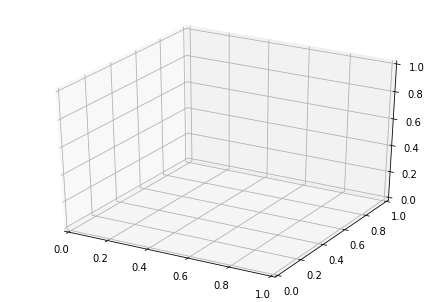

In [64]:
# 학습 결과 시각화
print("Q-value with Usable Ace")
plot_q_val(agent_renew, usable_ace = True)
print("Q-value without Usable Ace")
plot_q_val(agent_renew, usable_ace = False)

print("Optimal policy with Usable Ace : (RED : STICK, BLUE : HIT)")
usable_result = plot_action(agent_renew, usable_ace = True)
print("Optimal policy without Usable Ace : (RED : STICK, BLUE : HIT)")
no_usable_result = plot_action(agent_renew, usable_ace = False)

In [19]:
# 과제 1 : 플레이어와 딜러의 1000번 게임 진행
def renewal_game(dealer: Dealer, agent: Agent, deck: Deck, cardcounting) :
    
    # 게임 초기화 : 덱, 플레이어, 딜러 상태 초기화 및 딜러와 플레이어는 카드 2장씩 뽑는다.
    dealer.reset()
    agent.reset()
    agent.hit(deck)
    agent.hit(deck)
    dealer.hit(deck)
    dealer.hit(deck)

    # 에피소드 종료 여부 (True : 종료)
    done = False

    episode = list()                         # 에피소드
    dealer_show = dealer.show()             # 딜러가 플레이어에게 카드 1장을 보여준다.
    counting = cardcounting
    
    while not done:
        # 에피소드가 끝날 때까지 state, action, reward를 생성
        sums = agent.calculate_sum()
        if sums < 12:
            agent.hit(deck)                  # 플레이어는 합계가 12 이상이 될 때 까지 뽑는다.
            continue

        # 플레이어의 합계, 플레이어의 Ace 카드 여부, 딜러가 보여준 카드를 바탕으로 다음 수를 결정
        state = (sums, bool(agent.usable_ace), dealer_show, counting)
        
        # 정의한 state로 추가로 뽑을 것인지를 결정 (이미 결정된 policy를 기반으로 수행한다.)
        action = agent.policy(state)
        
        # 플레이어의 상태에 따라 딜러가 판단을 내림 (에피소드 종료, 혹은 게임 종료 후 reward 계산)
        done, reward = dealer.observation(action, agent, deck)
            
        # 생성된 state, action, reward를 에피소드에 추가 (이번 게임의 진행과 승, 패, 무승부)
        episode.append([state, action, reward])

    if deck.left_cards() < 15 :
        deck.reset()

    return episode
   

# 결과 집계를 위한 game count, game money 집계
Count_list = list()
Money_list = list()

# 기본 소지금(1만 달러), 승, 패, 무승부 (변수 초기화)
money = 10000
win = 0
loss = 0
draw = 0

# 1000번의 플레이 진행
for i in range(1000):
    counting = deck_renew.card_counting()
    # 매번 베팅 시 플레이어는 소지금 10달러를 지불
    episode = renewal_game(dealer_renew, agent_renew, deck_renew, counting)
    money -= 10
    

    if episode[-1][-1] == 1:        # 승리 : 20달러 획득 (베팅 금액 + 10달러)
        win += 1
        money += 20
    elif episode[-1][-1] == 0:      # 무승부 : 10달러 획득 (베팅 금액)
        draw += 1
        money += 10
    else:                           # 패배 : 소득 X (베팅 금액 손실)
        loss += 1
        
    # 매 게임마다 게임 번호, 소지금 내역을 리스트에 담아 시각화를 준비한다.
    Count_list.append(i + 1)
    Money_list.append(money)

In [20]:
# 과제 2 : 플레이어의 승률 계산
# MonteCarlo의 집계, (과제 1)에서의 출력 형태 참고
print("================= Game play 1000 times  ==================")
print("Player win rate :\t{:.3f}%".format(win / (win + loss) * 100))
print("Win :", win, "\nDraw :", draw, "\nLoss :", loss)

================= Game play 1000 times  ==================
Player win rate :	47.960%
Win : 435 
Draw : 93 
Loss : 472


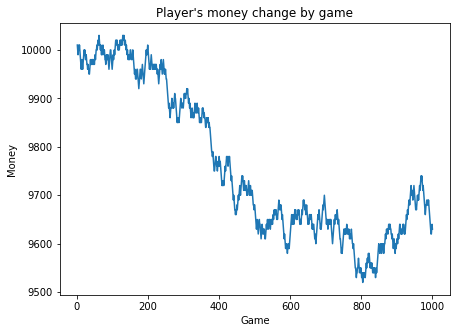

In [21]:
# 과제 3 : 플레이어의 소지금 변화 시각화
plt.figure(figsize = (7, 5))
plt.plot(Count_list, Money_list)
plt.xlabel('Game')
plt.ylabel('Money')
plt.title('Player\'s money change by game')
plt.show()

In [ ]:
# 추가 과제 2 : 베팅금액 변화
'''
카드 카운팅의 값이 +일 경우 아직 등장하지 않은 10, J, Q, K가 더 많이 있다는 뜻이다.
따라서 카드 카운팅 값이 5 이상일 경우 낮은 숫자는 적게 남고, 높은 숫자는 많이 남았기 때문에
딜러가 burst할 것을 노려, 승리 시 받을 금액을 높이는 것을 가정하여
플레이어가 얼마나 높은 금액을 얻을 지 확인해보았다.
'''

================= Game play 1000 times  ==================
Player win rate :	47.492%
Win : 426 
Draw : 103 
Loss : 471


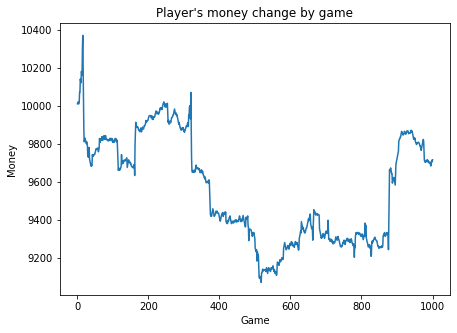

In [22]:
# 과제 1 : 플레이어와 딜러의 1000번 게임 진행
def renewal_game(dealer: Dealer, agent: Agent, deck: Deck, cardcounting) :
    
    # 게임 초기화 : 덱, 플레이어, 딜러 상태 초기화 및 딜러와 플레이어는 카드 2장씩 뽑는다.
    dealer.reset()
    agent.reset()
    agent.hit(deck)
    agent.hit(deck)
    dealer.hit(deck)
    dealer.hit(deck)

    # 에피소드 종료 여부 (True : 종료)
    done = False

    episode = list()                         # 에피소드
    dealer_show = dealer.show()             # 딜러가 플레이어에게 카드 1장을 보여준다.
    counting = cardcounting
    
    while not done:
        # 에피소드가 끝날 때까지 state, action, reward를 생성
        sums = agent.calculate_sum()
        if sums < 12:
            agent.hit(deck)                  # 플레이어는 합계가 12 이상이 될 때 까지 뽑는다.
            continue

        # 플레이어의 합계, 플레이어의 Ace 카드 여부, 딜러가 보여준 카드를 바탕으로 다음 수를 결정
        state = (sums, bool(agent.usable_ace), dealer_show, counting)
        
        # 정의한 state로 추가로 뽑을 것인지를 결정 (이미 결정된 policy를 기반으로 수행한다.)
        action = agent.policy(state)
        
        # 플레이어의 상태에 따라 딜러가 판단을 내림 (에피소드 종료, 혹은 게임 종료 후 reward 계산)
        done, reward = dealer.observation(action, agent, deck)
            
        # 생성된 state, action, reward를 에피소드에 추가 (이번 게임의 진행과 승, 패, 무승부)
        episode.append([state, action, reward])

    if deck.left_cards() < 15 :
        deck.reset()

    return episode
   

# 결과 집계를 위한 game count, game money 집계
Count_list = list()
Money_list = list()

# 기본 소지금(1만 달러), 승, 패, 무승부 (변수 초기화)
money = 10000
win = 0
loss = 0
draw = 0

# 1000번의 플레이 진행
for i in range(1000):
    counting = deck_renew.card_counting()
    
    # 카드 카운팅으로 배팅금액 조정
    betting = 10
    if counting >= 7 : 
        betting *= counting * 2
    elif counting >= 4 :
        betting *= (1 + counting)
    elif counting <= 0:
        betting *= (1 + counting * 0.25)
    money -= betting
    
    episode = renewal_game(dealer_renew, agent_renew, deck_renew, counting)

    if episode[-1][-1] == 1:        # 승리 : 20달러 획득 (베팅 금액 + 10달러)
        win += 1
        money += betting * 2
    elif episode[-1][-1] == 0:      # 무승부 : 10달러 획득 (베팅 금액)
        draw += 1
        money += betting
    else:                           # 패배 : 소득 X (베팅 금액 손실)
        loss += 1
        
    # 매 게임마다 게임 번호, 소지금 내역을 리스트에 담아 시각화를 준비한다.
    Count_list.append(i + 1)
    Money_list.append(money)
    
    
# 과제 2 : 플레이어의 승률 계산
# MonteCarlo의 집계, (과제 1)에서의 출력 형태 참고
print("================= Game play 1000 times  ==================")
print("Player win rate :\t{:.3f}%".format(win / (win + loss) * 100))
print("Win :", win, "\nDraw :", draw, "\nLoss :", loss)

# 과제 3 : 플레이어의 소지금 변화 시각화
plt.figure(figsize = (7, 5))
plt.plot(Count_list, Money_list)
plt.xlabel('Game')
plt.ylabel('Money')
plt.title('Player\'s money change by game')
plt.show()